In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import dates as mdates, transforms
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import (
    Rectangle, FancyBboxPatch, Polygon, Patch, Circle,
    Wedge, FancyArrowPatch
 )
from matplotlib.ticker import FuncFormatter
from datetime import datetime
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
DATA_PATH = 'erp_order_data.xlsx'
df = pd.read_excel(DATA_PATH)

REGION_MAPPING = {
    '北京': '华北', '天津': '华北', '河北省': '华北', '山西省': '华北', '内蒙古自治区': '华北',
    '辽宁省': '东北', '吉林省': '东北', '黑龙江省': '东北',
    '上海': '华东', '江苏省': '华东', '浙江省': '华东', '安徽省': '华东', '福建省': '华东',
    '江西省': '华东', '山东省': '华东',
    '河南省': '华中', '湖北省': '华中', '湖南省': '华中',
    '广东省': '华南', '广西壮族自治区': '华南', '海南省': '华南',
    '重庆': '西南', '四川省': '西南', '贵州省': '西南', '云南省': '西南', '西藏自治区': '西南',
    '陕西省': '西北', '甘肃省': '西北', '青海省': '西北', '宁夏回族自治区': '西北', '新疆维吾尔自治区': '西北'
}

province = df['province'] if 'province' in df.columns else None
if 'region' in df.columns:
    if province is not None:
        df['region'] = df['region'].fillna(province.map(REGION_MAPPING))
    df['region'] = df['region'].fillna('其他')
elif province is not None:
    df['region'] = province.map(REGION_MAPPING).fillna('其他')
else:
    df['region'] = '其他'

DATE_CANDIDATES = ['payment_date', 'order_date', 'create_time', 'created_at', 'date']
for col in DATE_CANDIDATES:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
PRIMARY_DATE_COL = next((c for c in DATE_CANDIDATES if c in df.columns), None)
PAYMENT_DATE_COL = 'payment_date' if 'payment_date' in df.columns else PRIMARY_DATE_COL
ORDER_DATE_COL = 'order_date' if 'order_date' in df.columns else PRIMARY_DATE_COL

AMOUNT_CANDIDATES = ['paid_amount', 'product_amount', 'amount', 'total_amount']
AMOUNT_COL = next((c for c in AMOUNT_CANDIDATES if c in df.columns), None)
QUANTITY_COL = 'quantity' if 'quantity' in df.columns else None

COST_CANDIDATES = ['cost_amount', 'cost', 'total_cost']
COST_COL = next((c for c in COST_CANDIDATES if c in df.columns), None)

def month_slice(frame, year, months=None, date_col=PRIMARY_DATE_COL):
    temp = frame.dropna(subset=[date_col])
    mask = temp[date_col].dt.year == year
    if months is not None:
        mask &= temp[date_col].dt.month.isin(months)
    return temp.loc[mask].copy()

def top_n_sum(frame, group_col, value_col, n=None, ascending=False):
    agg = frame.groupby(group_col, as_index=False)[value_col].sum()
    agg = agg.sort_values(value_col, ascending=ascending)
    return agg.head(n) if n else agg

NOTE_DATE = df[PRIMARY_DATE_COL].max()

print(df.head())
print(f"记录数：{len(df):,}，最近记录日期：{NOTE_DATE:%Y-%m-%d}")

KeyError: 'region'

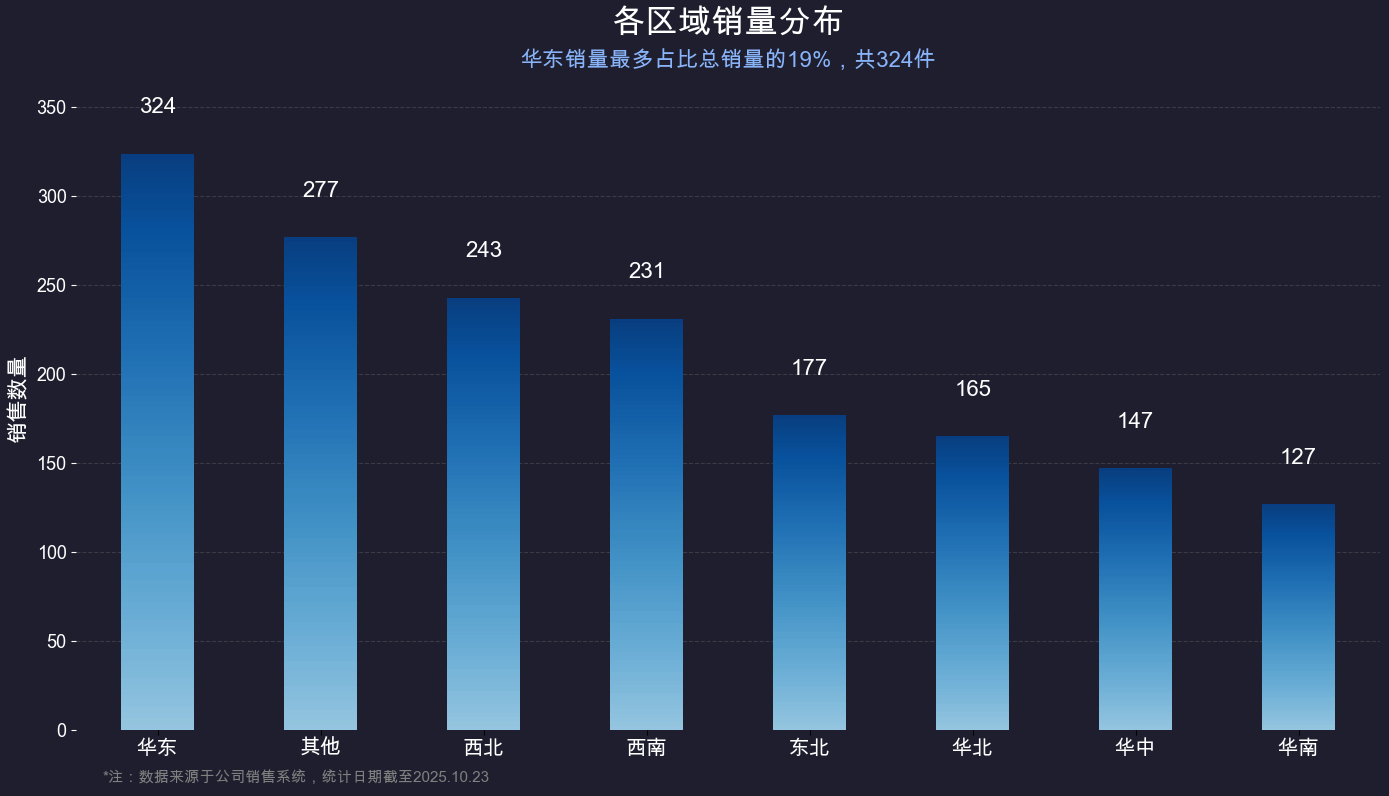


各区域销量统计：
region  total_quantity  order_count
    华东             324          178
    其他             277          170
    西北             243          152
    西南             231          128
    东北             177          109
    华北             165           94
    华中             147           94
    华南             127           75

总销量：1691 件
订单总数：1000 单


In [4]:
qty_col = QUANTITY_COL or AMOUNT_COL
region_stats = (
    df.groupby('region', as_index=False)
      .agg(total_quantity=(qty_col, 'sum'), order_count=('id', 'count'))
      .sort_values('total_quantity', ascending=False)
 )

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#1e1e2e')
ax.set_facecolor('#1e1e2e')

regions = region_stats['region'].to_list()
quantities = region_stats['total_quantity'].to_list()

bar_width = 0.45
gradient_steps = 100
cmap = mpl.colormaps.get_cmap('Blues')
layer_ratios = np.linspace(0, 1, gradient_steps, endpoint=False)
for i, qty in enumerate(quantities):
    layer_height = qty / gradient_steps
    for ratio in layer_ratios:
        y_position = ratio * qty
        color = cmap(0.4 + ratio * 0.55)
        rect = Rectangle((
            i - bar_width / 2, y_position
        ), bar_width, layer_height, facecolor=color, edgecolor='none')
        ax.add_patch(rect)
    ax.text(i, qty + 20, f'{int(qty)}', ha='center', va='bottom', fontsize=16, fontweight='bold', color='white')

ax.set_xticks(range(len(regions)))
ax.set_xticklabels(regions, fontsize=15, color='white')
ax.set_xlim(-0.5, len(regions) - 0.5)
ax.set_ylim(0, max(quantities) * 1.15)
ax.set_ylabel('销售数量', fontsize=16, fontweight='bold', color='white')
ax.tick_params(axis='y', colors='white', labelsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray', zorder=0)
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)

total_qty = region_stats['total_quantity'].sum()
top_region = region_stats.iloc[0]
percentage = top_region['total_quantity'] / total_qty * 100
ax.text(0.5, 1.05, '各区域销量分布', transform=ax.transAxes, fontsize=24, fontweight='bold', ha='center', color='white')
ax.text(0.5, 1.00, f"{top_region['region']}销量最多占比总销量的{percentage:.0f}%，共{int(top_region['total_quantity'])}件",
        transform=ax.transAxes, fontsize=16, ha='center', color='#89b4fa')
ax.text(0.02, -0.08, f'*注：数据来源于公司销售系统，统计日期截至{NOTE_DATE:%Y.%m.%d}',
        transform=ax.transAxes, fontsize=11, color='gray', style='italic')

plt.tight_layout()
plt.show()

print('\n各区域销量统计：')
print(region_stats.to_string(index=False))
print(f'\n总销量：{total_qty} 件')
print(f"订单总数：{df['id'].nunique()} 单")

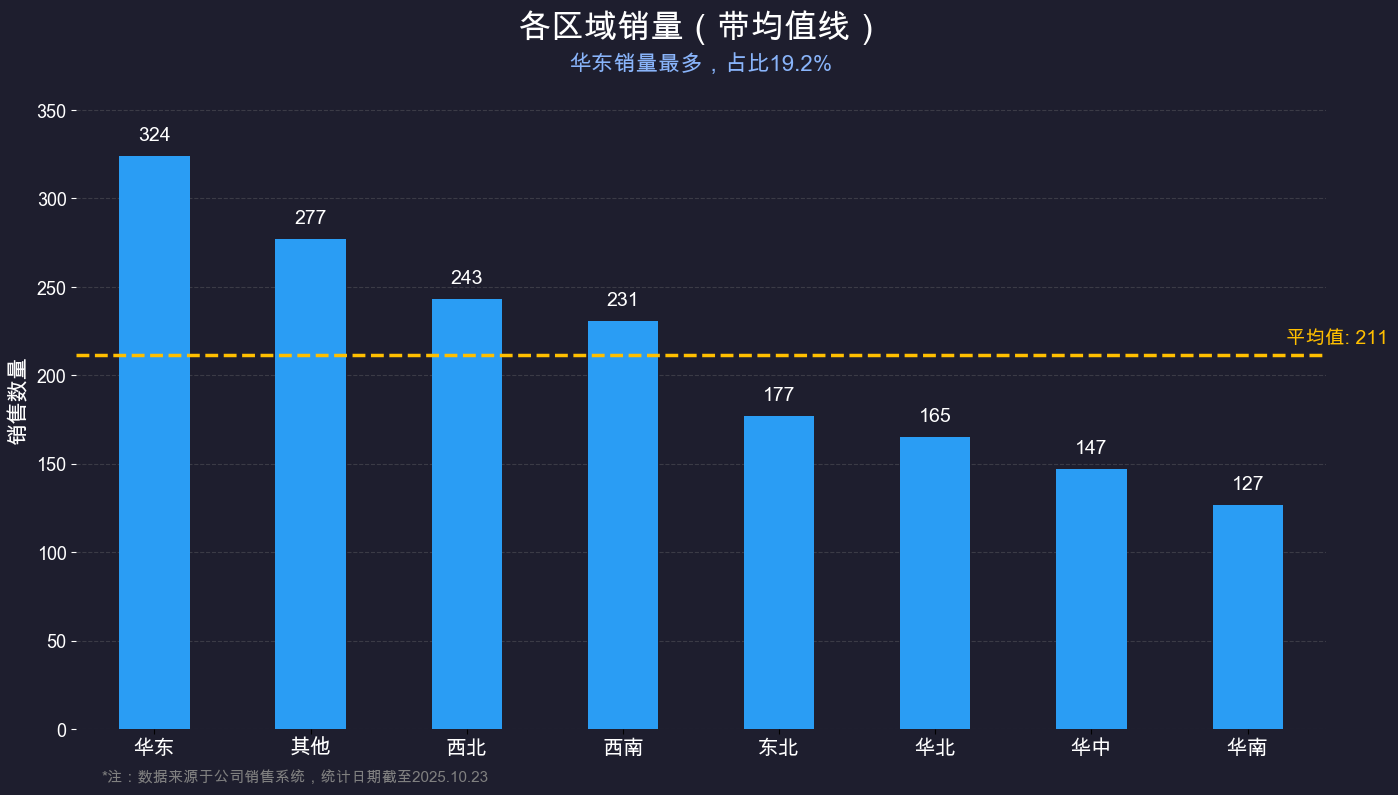


各区域销量统计：
region  total_quantity  order_count
    华东             324          178
    其他             277          170
    西北             243          152
    西南             231          128
    东北             177          109
    华北             165           94
    华中             147           94
    华南             127           75

平均销量: 211.38 件


In [5]:
def plot_region_bar_with_mean(region_stats, figsize=(12, 6), bar_color='#2a9df4'):
    regions = region_stats['region'].tolist()
    quantities = region_stats['total_quantity'].tolist()
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#1e1e2e')
    ax.set_facecolor('#1e1e2e')

    bars = ax.bar(x, quantities, color=bar_color, width=0.45, zorder=3)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + max(quantities) * 0.02,
                f'{int(h)}', ha='center', va='bottom', fontsize=14, color='white', fontweight='bold')

    mean_val = np.mean(quantities)
    ax.axhline(mean_val, color='#ffbf00', linestyle='--', linewidth=2.5, zorder=4)
    ax.text(len(regions) - 0.1, mean_val + max(quantities) * 0.02,
            f'平均值: {mean_val:.0f}', color='#ffbf00', fontsize=14, fontweight='bold', ha='right')

    ax.set_xticks(x)
    ax.set_xticklabels(regions, fontsize=15, color='white')
    ax.set_xlim(-0.5, len(regions) - 0.5)
    ax.set_ylim(0, max(quantities) * 1.15)
    ax.set_ylabel('销售数量', fontsize=16, fontweight='bold', color='white')
    ax.tick_params(axis='y', colors='white', labelsize=13)
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray', zorder=0)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)

    title_text = '各区域销量（带均值线）'
    subtitle_text = f"{region_stats.iloc[0]['region']}销量最多，占比{region_stats.iloc[0]['total_quantity'] / region_stats['total_quantity'].sum() * 100:.1f}%"
    ax.text(0.5, 1.05, title_text, transform=ax.transAxes, fontsize=24, fontweight='bold', ha='center', color='white')
    ax.text(0.5, 1.00, subtitle_text, transform=ax.transAxes, fontsize=16, ha='center', color='#89b4fa')
    ax.text(0.02, -0.08, f'*注：数据来源于公司销售系统，统计日期截至{NOTE_DATE:%Y.%m.%d}', transform=ax.transAxes, fontsize=11, color='gray', style='italic')

    plt.tight_layout()
    plt.show()
    return mean_val

mean_value = plot_region_bar_with_mean(region_stats, figsize=(14, 8))
print('\n各区域销量统计：')
print(region_stats.to_string(index=False))
print(f'\n平均销量: {mean_value:.2f} 件')

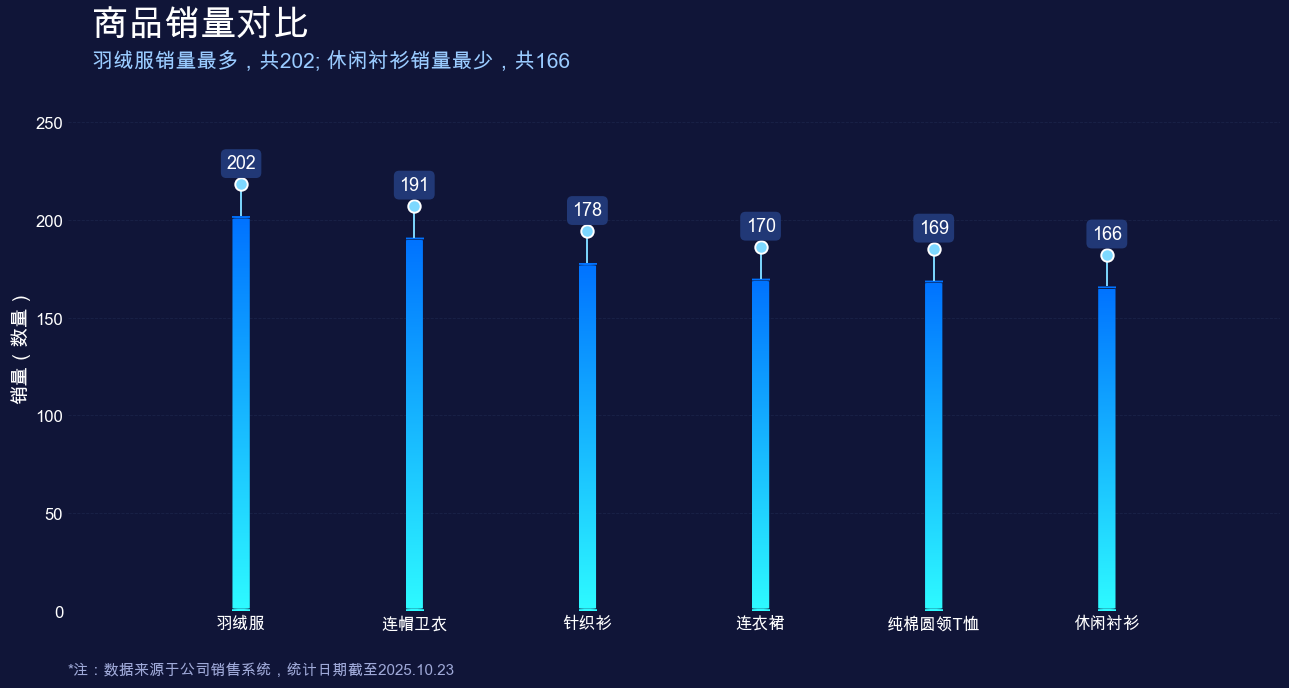


商品销量统计（Top）:
product_name  quantity
         羽绒服       202
        连帽卫衣       191
         针织衫       178
         连衣裙       170
      纯棉圆领T恤       169
        休闲衬衫       166


In [7]:
target_month = 3  # 需要展示的月份（1-12），若无月份数据会自动展示全部
top_n = 6        # 展示Top N 商品

if 'product_name' not in df.columns:
    raise ValueError('缺少字段 "product_name"，无法统计商品。')
value_col = QUANTITY_COL or AMOUNT_COL
date_col = ORDER_DATE_COL

# 保留只有在日期列存在且为 datetime 类型时按月份筛选，否则使用全部数据
df_products = df.dropna(subset=[date_col]).copy()

if pd.api.types.is_datetime64_any_dtype(df_products[date_col]):
    month_mask = df_products[date_col].dt.month == target_month
    month_data = df_products[month_mask]
else:
    month_data = df_products.copy()


data_view = df_products
note_date = None
month_label = ''


product_stats = (
    data_view.groupby('product_name', as_index=False)[value_col]
    .sum()
    .sort_values(value_col, ascending=False)
    .head(top_n)
 )
names = product_stats['product_name'].tolist()
values = product_stats[value_col].tolist()
max_val = max(values)

top_name = product_stats.iloc[0]['product_name']
top_qty = int(product_stats.iloc[0][value_col])
bottom_name = product_stats.iloc[-1]['product_name']
bottom_qty = int(product_stats.iloc[-1][value_col])

title_text = f"{month_label}商品销量对比" if month_label else "商品销量对比"
if month_label:
    subtitle_text = f"{top_name}销量最多，{month_label}销量{top_qty}; {bottom_name}最少，{month_label}销量{bottom_qty}"
else:
    subtitle_text = f"{top_name}销量最多，共{top_qty}; {bottom_name}销量最少，共{bottom_qty}"

bg_color = '#101538'
grid_color = '#2c3c66'
dot_color = '#7dd8ff'
value_bg = '#233c7c'

fig, ax = plt.subplots(figsize=(13, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

cmap = LinearSegmentedColormap.from_list('cyan_blue', ['#2efbff', '#0072ff'])
bar_width = 0.05
bar_spacing = 0.5
gradient_steps = 256
gradient_template = np.linspace(0, 1, gradient_steps).reshape(gradient_steps, 1)

x = np.arange(len(names)) * bar_spacing
bars = ax.bar(x, values, width=bar_width, color='none', edgecolor='none', zorder=2)

def bar_rounding(height):
    return np.clip(height * 0.02, bar_width * 6, bar_width * 28)

for bar, val in zip(bars, values):
    left = bar.get_x()
    rounding = bar_rounding(val)
    patch = FancyBboxPatch((left, 0), bar_width, val,
                            boxstyle=f'round,pad=0,rounding_size={rounding}',
                            linewidth=0, facecolor='none', edgecolor='none', zorder=4)
    ax.add_patch(patch)
    img = ax.imshow(gradient_template, extent=(left, left + bar_width, 0, val), origin='lower',
                    aspect='auto', cmap=cmap, zorder=3, interpolation='bicubic')
    img.set_clip_path(patch)

stem_height = max_val * 0.08
label_offset = max_val * 0.03

ax.vlines(x, values, np.array(values) + stem_height, colors=dot_color, linewidth=1.4, zorder=5)
ax.scatter(x, np.array(values) + stem_height, s=80, color=dot_color, edgecolors='white', linewidth=1.4, zorder=6)

for xi, val in zip(x, values):
    ax.text(xi, val + stem_height + label_offset, f"{int(val)}",
            ha='center', va='bottom', fontsize=13, color='white', fontweight='bold', zorder=7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=value_bg, edgecolor='none', alpha=0.92))

ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=13, color='white')
pad = max(bar_width * 3, bar_spacing)
if len(x):
    x_min, x_max = float(np.min(x)), float(np.max(x))
else:
    x_min = x_max = 0.0
ax.set_xlim(x_min - pad, x_max + pad)
ax.set_ylim(0, max_val * 1.35)
ax.set_ylabel('销量（数量）', fontsize=14, color='white')
ax.tick_params(axis='both', colors='white', labelsize=12, width=0.8, length=0)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', color=grid_color, alpha=0.35, linewidth=0.6)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(0.02, 1.08, title_text, transform=ax.transAxes, fontsize=26, fontweight='bold',
        ha='left', color='white')
ax.text(0.02, 1.02, subtitle_text, transform=ax.transAxes, fontsize=15,
        ha='left', color='#9acbff')

note_text = '*注：数据来源于公司销售系统'
ref_date = note_date or NOTE_DATE
if pd.notna(ref_date):
    note_text += f"，统计日期截至{ref_date:%Y.%m.%d}"
ax.text(0.0, -0.12, note_text, transform=ax.transAxes, fontsize=11, color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

print('\n商品销量统计（Top）:')
print(product_stats[['product_name', value_col]].to_string(index=False))

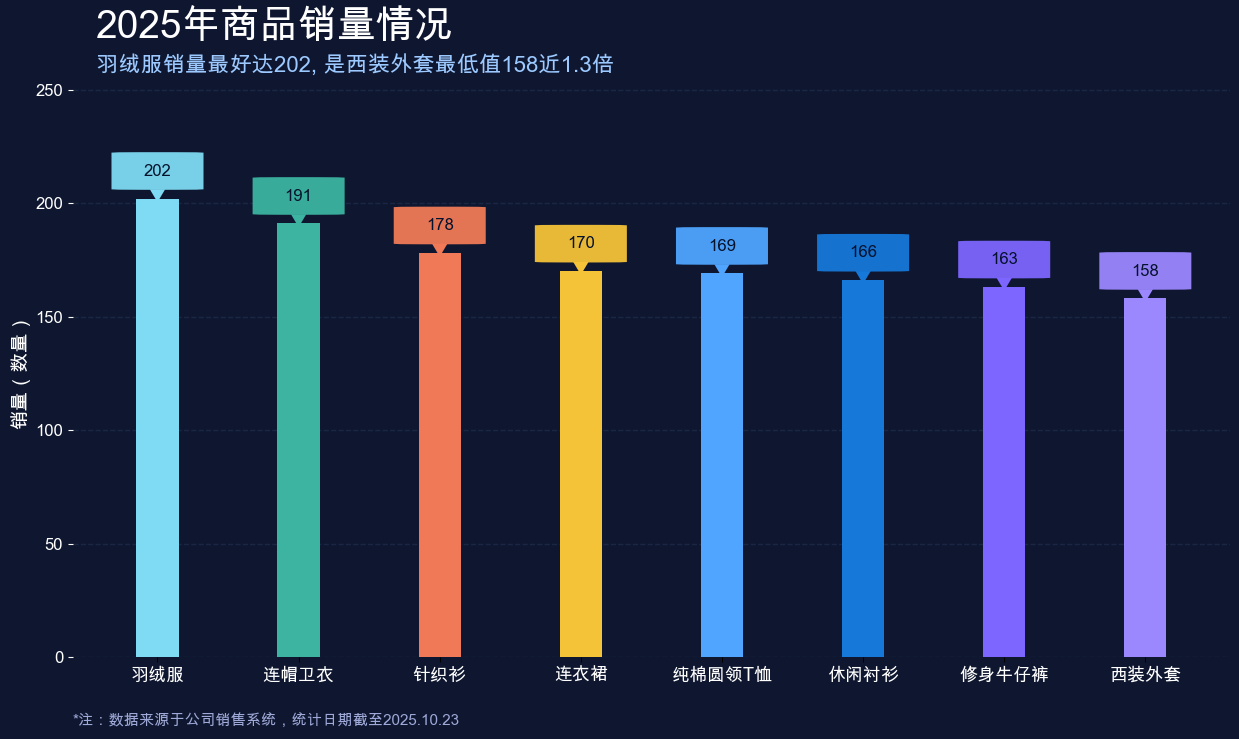

In [ ]:
top_n = 8
value_col = QUANTITY_COL or AMOUNT_COL
category_stats = (
    df.groupby('product_name', as_index=False)[value_col]
    .sum()
    .sort_values(value_col, ascending=False)
    .head(top_n)
 )

names = category_stats['product_name'].tolist()
values = category_stats[value_col].tolist()
x = np.arange(len(names))
max_val = max(values)

palette = ['#7edbf3', '#3cb4a1', '#f07a57', '#f4c338', '#4fa5ff', '#1678d8', '#7d66ff', '#9b88ff']
if len(palette) < len(names):
    repeats = int(np.ceil(len(names) / len(palette)))
    palette = (palette * repeats)[:len(names)]

bg_color = '#0f1730'
grid_color = '#2b3f63'
title_text = '2025年商品销量情况'
subtitle_text = f"{names[0]}销量最好达{values[0]}, 是{names[-1]}最低值{values[-1]}近{values[0] / values[-1]:.1f}倍"
note_text = f"*注：数据来源于公司销售系统，统计日期截至{NOTE_DATE:%Y.%m.%d}"

fig, ax = plt.subplots(figsize=(12.5, 7.5))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

bar_width = 0.3
bars = ax.bar(x, values, color=palette[:len(names)], width=bar_width, edgecolor='none', zorder=2)

gap = max_val * 0.02
label_height = max_val * 0.08
triangle_half = bar_width * 0.18

for xi, val, color in zip(x, values, palette):
    rect = FancyBboxPatch((xi - bar_width * 0.42, val + gap),
                          bar_width * 0.84, label_height,
                          boxstyle='round,pad=0.2',
                          facecolor=color, edgecolor='none', zorder=4, alpha=0.95)
    ax.add_patch(rect)
    pointer = Polygon([[xi - triangle_half, val + gap],
                       [xi + triangle_half, val + gap],
                       [xi, val + gap - label_height * 0.35]],
                      closed=True, facecolor=color, edgecolor='none', zorder=3)
    ax.add_patch(pointer)
    ax.text(xi, val + gap + label_height / 2, f"{int(val)}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            color='#05122d', zorder=5)

ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=13, color='white')
ax.set_ylim(0, max_val * 1.25)
ax.set_xlim(-0.6, len(names) - 0.4)
ax.set_ylabel('销量（数量）', fontsize=14, color='white')
ax.tick_params(axis='y', colors='white', labelsize=12)
ax.yaxis.grid(True, linestyle='--', color=grid_color, alpha=0.4, linewidth=1, zorder=1)
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(0.02, 1.08, title_text, transform=ax.transAxes, fontsize=28, fontweight='bold',
        ha='left', color='white')
ax.text(0.02, 1.02, subtitle_text, transform=ax.transAxes, fontsize=16,
        ha='left', color='#9cc9ff')
ax.text(0.0, -0.12, note_text, transform=ax.transAxes, fontsize=11,
        color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

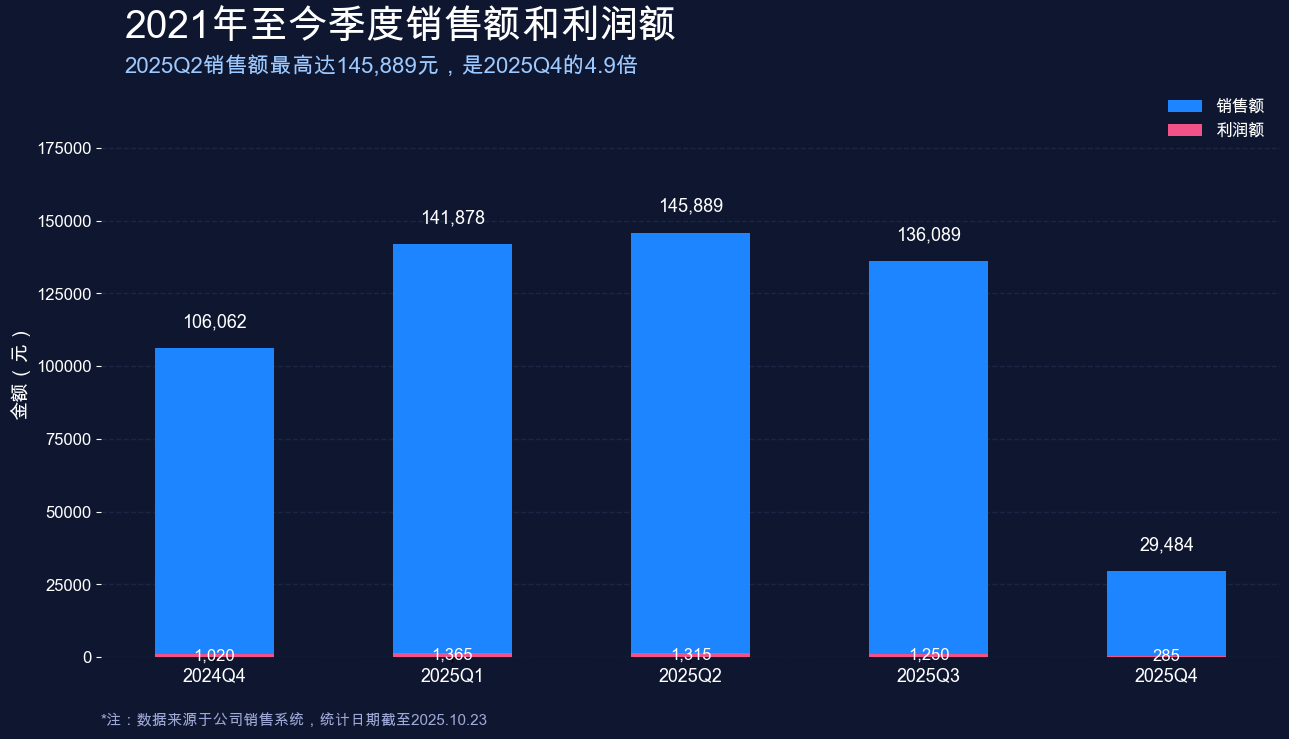

In [ ]:
df_quarter = df.dropna(subset=[PAYMENT_DATE_COL]).copy()
if 'product_amount' not in df_quarter.columns:
    if {'unit_price', QUANTITY_COL}.issubset(df_quarter.columns):
        df_quarter['product_amount'] = df_quarter['unit_price'] * df_quarter[QUANTITY_COL]
    elif COST_COL:
        df_quarter['product_amount'] = df_quarter[COST_COL]
    else:
        raise ValueError('缺少成本字段，无法估算利润。')

sales_col = 'paid_amount' if 'paid_amount' in df_quarter.columns else AMOUNT_COL

df_quarter['quarter_period'] = df_quarter[PAYMENT_DATE_COL].dt.to_period('Q')
agg = df_quarter.groupby('quarter_period').agg(
    sales_amount=(sales_col, 'sum'),
    cost_amount=('product_amount', 'sum')
).reset_index()
agg['profit_amount'] = (agg['sales_amount'] - agg['cost_amount']).clip(lower=0)
agg = agg.sort_values('quarter_period')
agg['quarter_label'] = agg['quarter_period'].astype(str)

recent_quarters = 6
if len(agg) > recent_quarters:
    agg = agg.tail(recent_quarters).reset_index(drop=True)
sales = agg['sales_amount'].to_numpy()
profit = agg['profit_amount'].to_numpy()
non_profit = np.clip(sales - profit, a_min=0, a_max=None)

quarters = agg['quarter_label'].tolist()
x = np.arange(len(quarters))

bg_color = '#0f1730'
grid_color = '#2b3f63'
sales_color = '#1c85ff'
profit_color = '#f25287'

fig, ax = plt.subplots(figsize=(13, 7.5))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

bar_width = 0.5
profit_bars = ax.bar(x, profit, width=bar_width, color=profit_color, edgecolor='none', zorder=2)
sales_bars = ax.bar(x, non_profit, width=bar_width, bottom=profit, color=sales_color, edgecolor='none', zorder=3)

max_total = sales.max()
label_offset = max_total * 0.04

for xi, total, pr in zip(x, sales, profit):
    if pr > 0:
        ax.text(xi, pr / 2, f"{pr:,.0f}", color='white', fontsize=12, fontweight='bold', ha='center', va='center')
    ax.text(xi, total + label_offset, f"{total:,.0f}", color='white', fontsize=13, fontweight='bold', ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(quarters, fontsize=13, color='white')
ax.set_ylim(0, max_total * 1.35)
ax.set_ylabel('金额（元）', fontsize=14, color='white')
ax.tick_params(axis='y', colors='white', labelsize=12)
ax.yaxis.grid(True, linestyle='--', color=grid_color, alpha=0.4, linewidth=1, zorder=1)
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)

legend_elements = [
    Patch(facecolor=sales_color, edgecolor='none', label='销售额'),
    Patch(facecolor=profit_color, edgecolor='none', label='利润额')
 ]
legend = ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
for text in legend.get_texts():
    text.set_color('white')

top_row = agg.loc[sales.argmax()]
bottom_row = agg.loc[sales.argmin()]
ratio = (top_row['sales_amount'] / bottom_row['sales_amount']) if bottom_row['sales_amount'] else np.nan
subtitle_text = f"{top_row['quarter_label']}销售额最高达{top_row['sales_amount']:,.0f}元"
if np.isfinite(ratio) and ratio > 0:
    subtitle_text += f"，是{bottom_row['quarter_label']}的{ratio:.1f}倍"
note_date = df_quarter[PAYMENT_DATE_COL].max() or NOTE_DATE
ax.text(0.02, 1.08, '2021年至今季度销售额和利润额', transform=ax.transAxes, fontsize=28, fontweight='bold', ha='left', color='white')
ax.text(0.02, 1.02, subtitle_text, transform=ax.transAxes, fontsize=16, ha='left', color='#9cc9ff')
ax.text(0.0, -0.12, f"*注：数据来源于公司销售系统，统计日期截至{note_date:%Y.%m.%d}", transform=ax.transAxes, fontsize=11, color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

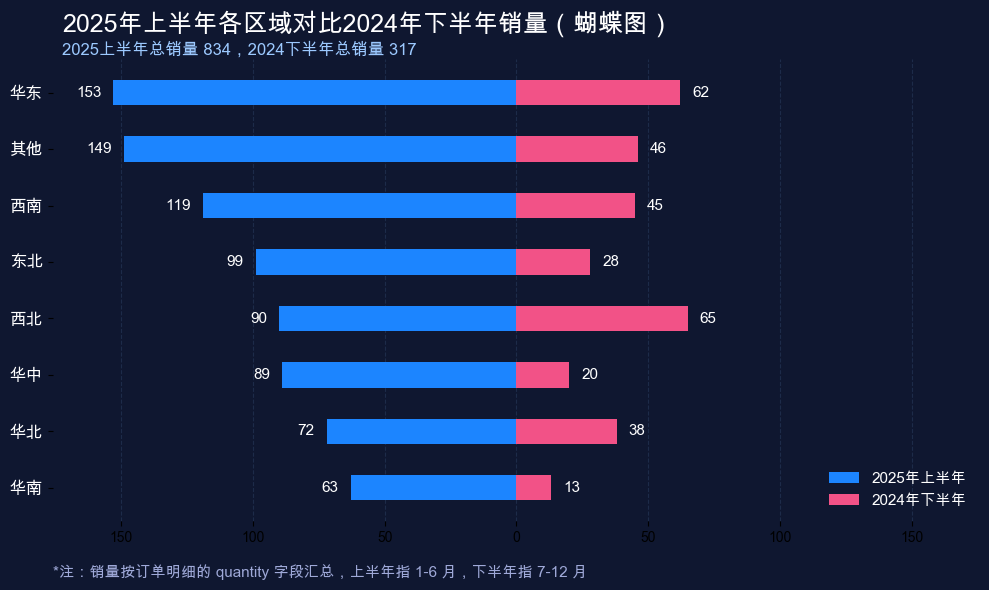

In [ ]:
value_col = QUANTITY_COL or AMOUNT_COL
date_col = PAYMENT_DATE_COL
df_time = df.dropna(subset=[date_col]).copy()

h1_2025 = df_time[(df_time[date_col].dt.year == 2025) & (df_time[date_col].dt.month <= 6)]
h2_2024 = df_time[(df_time[date_col].dt.year == 2024) & (df_time[date_col].dt.month >= 7)]

agg25 = h1_2025.groupby('region', as_index=True)[value_col].sum().rename('sales_2025')
agg24 = h2_2024.groupby('region', as_index=True)[value_col].sum().rename('sales_2024')

comp = pd.concat([agg25, agg24], axis=1).fillna(0)
comp = comp.sort_values('sales_2025', ascending=False)
regions = comp.index.tolist()
sales25 = comp['sales_2025'].values
sales24 = comp['sales_2024'].values

left = -sales25
right = sales24
y = np.arange(len(regions))

bg = '#0f1730'
left_color = '#1c85ff'
right_color = '#f25287'
grid_color = '#2b3f63'

fig, ax = plt.subplots(figsize=(10, max(6, len(regions)*0.6)))
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

bar_height = 0.45
ax.barh(y, left, height=bar_height, color=left_color, zorder=3)
ax.barh(y, right, height=bar_height, color=right_color, zorder=3)

max_val = max(sales25.max() if len(sales25)>0 else 0, sales24.max() if len(sales24)>0 else 0)
pad = max_val * 0.03 if max_val>0 else 1

for yi, a, b in zip(y, left, right):
    ax.text(a - pad, yi, f"{int(abs(a)):,.0f}", ha='right', va='center', color='white', fontsize=11, fontweight='bold')
    ax.text(b + pad, yi, f"{int(b):,.0f}", ha='left', va='center', color='white', fontsize=11, fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(regions, fontsize=12, color='white')

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(abs(x)):,.0f}"))
ax.set_xlim(-max_val*1.15, max_val*1.15)
ax.invert_yaxis()
ax.xaxis.grid(True, linestyle='--', color=grid_color, alpha=0.5, zorder=0)
for spine in ax.spines.values():
    spine.set_visible(False)

legend = ax.legend([Patch(facecolor=left_color), Patch(facecolor=right_color)], ['2025年上半年','2024年下半年'], loc='lower right', frameon=False, fontsize=11)
for t in legend.get_texts():
    t.set_color('white')

total25 = int(sales25.sum())
total24 = int(sales24.sum())
subtitle = f"2025上半年总销量 {total25:,d}，2024下半年总销量 {total24:,d}"
ax.text(0.01, 1.06, '2025年上半年各区域对比2024年下半年销量（蝴蝶图）', transform=ax.transAxes, fontsize=18, fontweight='bold', ha='left', color='white')
ax.text(0.01, 1.01, subtitle, transform=ax.transAxes, fontsize=12, ha='left', color='#9cc9ff')
ax.text(0.0, -0.12, '*注：销量按订单明细的 quantity 字段汇总，上半年指 1-6 月，下半年指 7-12 月', transform=ax.transAxes, fontsize=11, color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

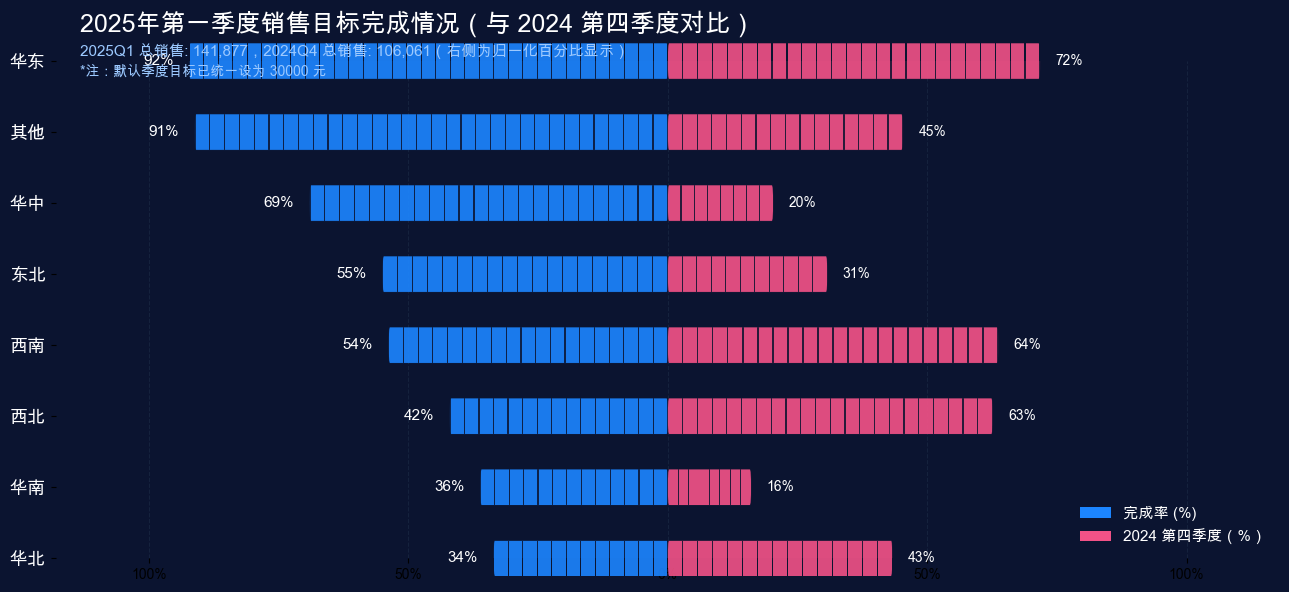

In [ ]:
q1_months = [1, 2, 3]
df_q1 = month_slice(df, 2025, q1_months, date_col=PAYMENT_DATE_COL)
sales_col = 'paid_amount' if 'paid_amount' in df_q1.columns else AMOUNT_COL
agg_sales = df_q1.groupby('region', as_index=True)[sales_col].sum().rename('sales')

if 'target_amount' in df_q1.columns:
    agg_target = df_q1.groupby('region', as_index=True)['target_amount'].sum().rename('target')
else:
    quarterly_target = 30000.0
    agg_target = pd.Series(quarterly_target, index=agg_sales.index, name='target')

df_2024_q4 = month_slice(df, 2024, [10, 11, 12], date_col=PAYMENT_DATE_COL)
agg_2024_q4 = df_2024_q4.groupby('region', as_index=True)[sales_col].sum().rename('sales_2024_q4')

comp = pd.concat([agg_sales, agg_target, agg_2024_q4], axis=1).fillna(0)
comp = comp.sort_values('sales', ascending=False)
regions = comp.index.tolist()
sales = comp['sales'].values.astype(float)
targets = comp['target'].values.astype(float)
sales_2024_q4 = comp['sales_2024_q4'].values.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    complete_pct = np.where(targets > 0, sales / targets * 100.0, 0.0)

norm_base = max(sales_2024_q4.max() if len(sales_2024_q4)>0 else 0, targets.max() if len(targets)>0 else 0, 1)
right_pct = (sales_2024_q4 / norm_base) * 100.0

bg = '#0b1430'
left_color = '#1c85ff'
right_color = '#f25287'
grid_color = '#23344f'
accent = '#9cc9ff'

fig, ax = plt.subplots(figsize=(13, max(6, len(regions)*0.6)))
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

y = np.arange(len(regions))
bar_h = 0.5
max_pct = max(complete_pct.max() if len(complete_pct)>0 else 0, 100)

def draw_rounded_striped(ax, x_start, width, y_center, height, color, n_stripes=24, gap_ratio=0.08):
    rounding = height/2
    clip = FancyBboxPatch((x_start, y_center - height/2), width, height, boxstyle=f'round,pad=0,rounding_size={rounding}', linewidth=0, facecolor='none')
    ax.add_patch(clip)
    base = FancyBboxPatch((x_start, y_center - height/2), width, height, boxstyle=f'round,pad=0,rounding_size={rounding}', linewidth=0, facecolor=color, alpha=0.12, zorder=2)
    ax.add_patch(base)
    stripe_w = width / max(1, n_stripes)
    space = stripe_w * gap_ratio
    for i in range(n_stripes):
        sx = x_start + i*stripe_w + space/2
        sw = max(0, stripe_w - space)
        if sw <= 0:
            continue
        r = Rectangle((sx, y_center-height/2), sw, height, facecolor=color, edgecolor='none', zorder=3, alpha=0.9)
        r.set_clip_path(clip)
        ax.add_patch(r)
    edge = FancyBboxPatch((x_start, y_center - height/2), width, height, boxstyle=f'round,pad=0,rounding_size={rounding}', linewidth=0.6, facecolor='none', edgecolor=color, alpha=0.12, zorder=4)
    ax.add_patch(edge)

for yi, pct in zip(y, complete_pct):
    if pct > 0:
        n = max(8, int(pct/100*36))
        draw_rounded_striped(ax, -pct, pct, yi, bar_h, left_color, n_stripes=n)
for yi, rp in zip(y, right_pct):
    if rp > 0:
        n = max(8, int(rp/100*36))
        draw_rounded_striped(ax, 0.0, rp, yi, bar_h, right_color, n_stripes=n)

pad = max_pct * 0.03
for yi, pct, rp in zip(y, complete_pct, right_pct):
    left_text = f'{pct:.0f}%' if pct > 0 else '-'
    right_text = f'{rp:.0f}%' if np.isfinite(rp) and rp > 0 else '-'
    ax.text(-pct - pad if pct > 0 else -pad, yi, left_text, ha='right', va='center', color='white', fontsize=11, fontweight='bold')
    ax.text(rp + pad if np.isfinite(rp) and rp > 0 else pad, yi, right_text, ha='left', va='center', color='white', fontsize=10, fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(regions, fontsize=13, color='white')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(abs(x))}%'))
ax.set_xlim(-max_pct - 18, 118)
ax.invert_yaxis()
ax.xaxis.grid(True, linestyle='--', color=grid_color, alpha=0.45)
for s in ax.spines.values():
    s.set_visible(False)

legend = ax.legend([Patch(facecolor=left_color), Patch(facecolor=right_color)], ['完成率 (%)','2024 第四季度（%）'], loc='lower right', frameon=False, fontsize=11)
for t in legend.get_texts():
    t.set_color('white')

total_q1 = int(sales.sum())
total_2024_q4 = int(sales_2024_q4.sum())
ax.text(0.02, 1.06, '2025年第一季度销售目标完成情况（与 2024 第四季度对比）', transform=ax.transAxes, fontsize=18, fontweight='bold', ha='left', color='white')
subtitle = f'2025Q1 总销售: {total_q1:,d}，2024Q4 总销售: {total_2024_q4:,d}（右侧为归一化百分比显示）'
ax.text(0.02, 1.01, subtitle, transform=ax.transAxes, fontsize=11, ha='left', color=accent)
ax.text(0.02, 0.97, '*注：默认季度目标已统一设为 30000 元', transform=ax.transAxes, fontsize=10, ha='left', color=accent)

plt.tight_layout()
plt.show()

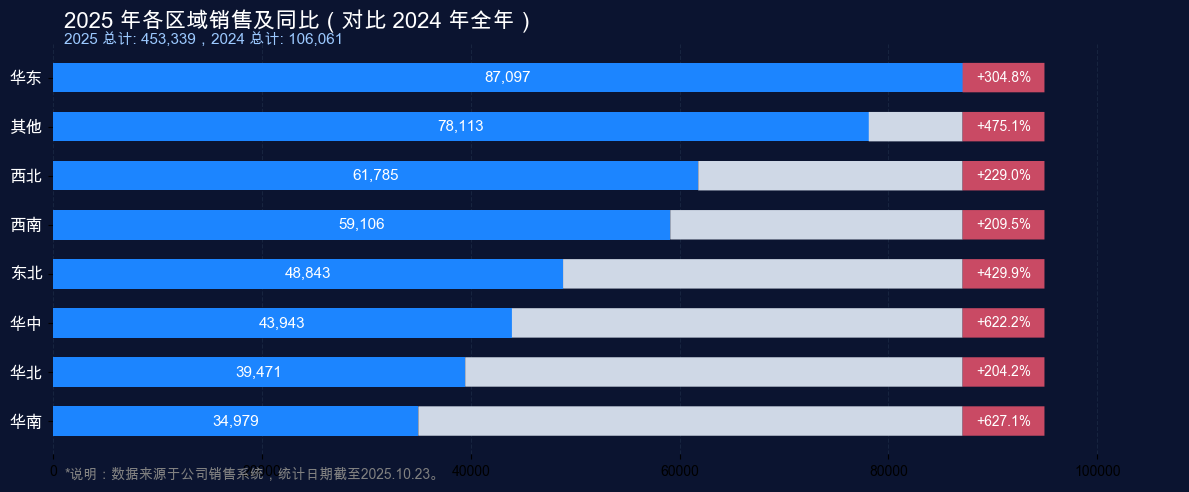

In [ ]:
date_col = PAYMENT_DATE_COL
df_time = df.dropna(subset=[date_col]).copy()

amount_col = 'paid_amount' if 'paid_amount' in df_time.columns else AMOUNT_COL

df_2025 = df_time[df_time[date_col].dt.year == 2025].copy()
df_2024 = df_time[df_time[date_col].dt.year == 2024].copy()
agg_2025 = df_2025.groupby('region', as_index=True)[amount_col].sum().rename('sales_2025')
agg_2024 = df_2024.groupby('region', as_index=True)[amount_col].sum().rename('sales_2024')

comp = pd.concat([agg_2025, agg_2024], axis=1).fillna(0)
comp = comp.sort_values('sales_2025', ascending=False)
regions = comp.index.tolist()
sales_2025 = comp['sales_2025'].values.astype(float)
sales_2024 = comp['sales_2024'].values.astype(float)

with np.errstate(divide='ignore', invalid='ignore'):
    yoy_pct = np.where(sales_2024 > 0, (sales_2025 - sales_2024) / sales_2024 * 100.0, np.nan)

bg = '#0b1430'
bar_color = '#1c85ff'
y = np.arange(len(regions))
fig, ax = plt.subplots(figsize=(12, max(5, len(regions)*0.5)))
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

max_val = max(sales_2025.max() if len(sales_2025)>0 else 0, 1)
bar_h = 0.6
bars = ax.barh(y, sales_2025, color=bar_color, height=bar_h, zorder=3)

text_inside_threshold = max_val * 0.08
for yi, val, pct in zip(y, sales_2025, yoy_pct):
    text = f'{int(val):,d}'
    if val >= text_inside_threshold:
        ax.text(val/2, yi, text, va='center', ha='center', color='white', fontsize=11, fontweight='bold')
    else:
        ax.text(val + max_val*0.01, yi, text, va='center', ha='left', color='white', fontsize=11, fontweight='bold')

left_limit, right_limit = ax.get_xlim()
extra_frac = 0.18
ax.set_xlim(left_limit, right_limit + (right_limit - left_limit) * extra_frac)
x_min, x_max = ax.get_xlim()

box_h = bar_h
box_pad = max_val * 0.02
box_w_min = max_val * 0.02
box_w_fixed = max_val * 0.09

max_idx = int(np.nanargmax(sales_2025)) if len(sales_2025) > 0 else 0
for i, yi in enumerate(y):
    val = float(sales_2025[i]) if i < len(sales_2025) else 0.0
    gray_width = max(0.0, max_val - val)
    if gray_width > 0:
        gray_width = max(gray_width, box_w_min)
    if i != max_idx and gray_width > 0:
        b1_left = val
        b1 = FancyBboxPatch((b1_left, yi - box_h/2), gray_width, box_h,
                            boxstyle=f'round,pad=0,rounding_size={box_h/2}',
                            linewidth=0, facecolor='#cfd8e6', edgecolor='none', zorder=6)
        ax.add_patch(b1)
    red_left = val + (gray_width if (i != max_idx and gray_width>0) else 0.0)
    b2 = FancyBboxPatch((red_left, yi - box_h/2), box_w_fixed, box_h,
                        boxstyle=f'round,pad=0,rounding_size={box_h/2}',
                        linewidth=0, facecolor='#c94a64', edgecolor='none', zorder=6)
    ax.add_patch(b2)
    growth = yoy_pct[i] if i < len(yoy_pct) else np.nan
    growth_str = f'{growth:+.1f}%' if np.isfinite(growth) else '-'
    ax.text(red_left + box_w_fixed/2, yi, growth_str, ha='center', va='center', color='white', fontsize=10, fontweight='bold', zorder=7)

ax.set_yticks(y)
ax.set_yticklabels(regions, fontsize=12, color='white')
ax.invert_yaxis()
ax.xaxis.grid(True, linestyle='--', color='#23344f', alpha=0.5)
for s in ax.spines.values():
    s.set_visible(False)

total_2025 = int(sales_2025.sum())
total_2024 = int(sales_2024.sum())
ax.text(0.01, 1.04, '2025 年各区域销售及同比（对比 2024 年全年）', transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', color='white')
ax.text(0.01, 1.00, f'2025 总计: {total_2025:,d}，2024 总计: {total_2024:,d}', transform=ax.transAxes, fontsize=11, ha='left', color='#9cc9ff')
ax.text(0.01, -0.06, f'*说明：数据来源于公司销售系统，统计日期截至{NOTE_DATE:%Y.%m.%d}。', transform=ax.transAxes, fontsize=10, ha='left', color='gray')

plt.tight_layout()
plt.show()

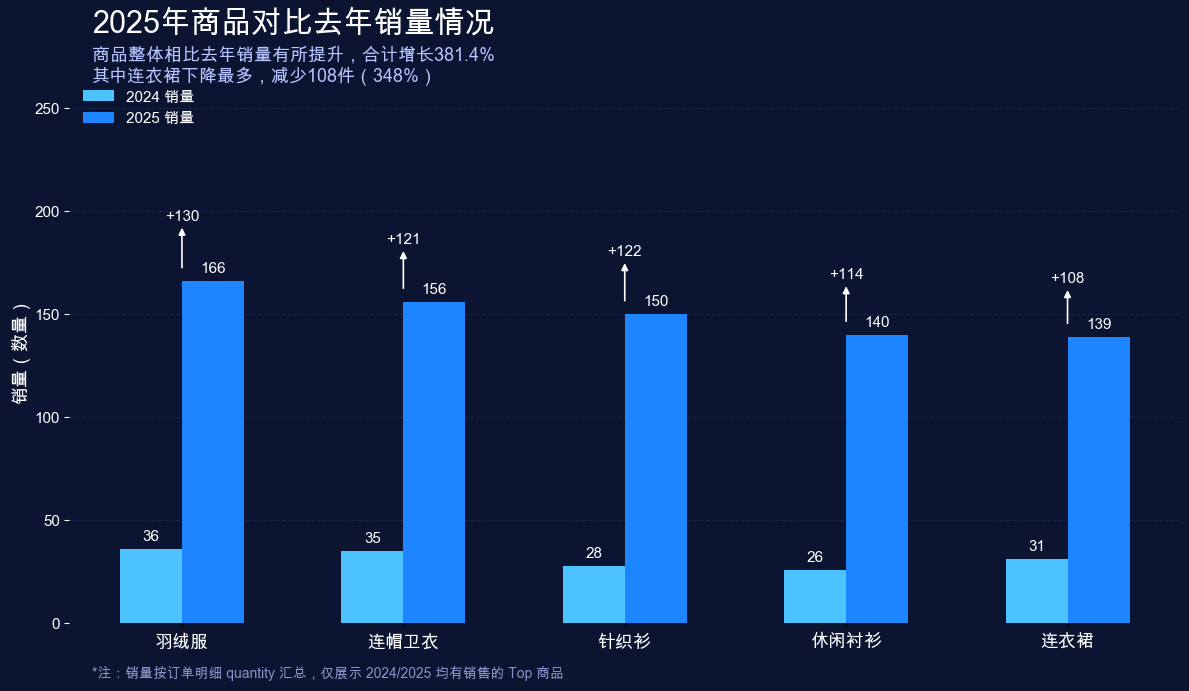

In [ ]:
date_col = PAYMENT_DATE_COL
df_year = df.dropna(subset=[date_col]).copy()
df_year['year'] = df_year[date_col].dt.year

pivot = (
    df_year[df_year['year'].isin([2024, 2025])]
    .groupby(['product_name', 'year'], as_index=False)[QUANTITY_COL]
    .sum()
    .pivot(index='product_name', columns='year', values=QUANTITY_COL)
 )
for col in [2024, 2025]:
    if col not in pivot.columns:
        pivot[col] = 0
pivot = pivot.fillna(0)

top_n = 5
pivot = pivot.sort_values(2025, ascending=False).head(top_n)

names = pivot.index.tolist()
val_2024 = pivot[2024].to_numpy(dtype=float)
val_2025 = pivot[2025].to_numpy(dtype=float)
diff = val_2025 - val_2024

x = np.arange(len(names))
bar_width = 0.28

bg_color = '#0b1430'
bar_2024_color = '#4cc3ff'
bar_2025_color = '#1c85ff'
arrow_color = 'white'
grid_color = '#30466d'

fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

bars_2024 = ax.bar(x - bar_width/2, val_2024, width=bar_width,
                   color=bar_2024_color, edgecolor='none', zorder=3)
bars_2025 = ax.bar(x + bar_width/2, val_2025, width=bar_width,
                   color=bar_2025_color, edgecolor='none', zorder=3)

max_val = max(val_2024.max() if len(val_2024) > 0 else 0,
              val_2025.max() if len(val_2025) > 0 else 0)
label_offset = max_val * 0.04 if max_val > 0 else 1

for b4, b5, v4, v5 in zip(bars_2024, bars_2025, val_2024, val_2025):
    ax.text(b4.get_x() + b4.get_width()/2, v4 + label_offset*0.4,
            f'{int(v4):,d}', ha='center', va='bottom',
            fontsize=11, color='white')
    ax.text(b5.get_x() + b5.get_width()/2, v5 + label_offset*0.4,
            f'{int(v5):,d}', ha='center', va='bottom',
            fontsize=11, color='white')

for xi, v4, v5, d in zip(x, val_2024, val_2025, diff):
    base_y = max(v4, v5) + label_offset * 0.8
    top_y = base_y + abs(d) * 0.15 + label_offset * 0.4
    if d > 0:
        arrow = FancyArrowPatch((xi, base_y), (xi, top_y),
                                arrowstyle='-|>', mutation_scale=10,
                                linewidth=1.2, color=arrow_color, zorder=4)
        ax.add_patch(arrow)
        ax.text(xi, top_y + label_offset*0.1, f'+{int(d):,d}',
                ha='center', va='bottom', fontsize=11, color='white')
    elif d < 0:
        arrow = FancyArrowPatch((xi, top_y), (xi, base_y),
                                arrowstyle='-|>', mutation_scale=10,
                                linewidth=1.2, color=arrow_color, zorder=4)
        ax.add_patch(arrow)
        ax.text(xi, top_y + label_offset*0.1, f'{int(d):,d}',
                ha='center', va='bottom', fontsize=11, color='white')

ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=13, color='white')
ax.set_ylabel('销量（数量）', fontsize=13, color='white')
ax.tick_params(axis='y', colors='white', labelsize=11)
ax.yaxis.grid(True, linestyle='--', color=grid_color, alpha=0.4)
ax.set_axisbelow(True)
ax.set_ylim(0, max_val * 1.6 if max_val > 0 else 10)
for spine in ax.spines.values():
    spine.set_visible(False)

legend_elems = [
    Patch(facecolor=bar_2024_color, edgecolor='none', label='2024 销量'),
    Patch(facecolor=bar_2025_color, edgecolor='none', label='2025 销量'),
]
leg = ax.legend(handles=legend_elems, loc='upper left', frameon=False, fontsize=11)
for t in leg.get_texts():
    t.set_color('white')

total_2024 = int(val_2024.sum())
total_2025 = int(val_2025.sum())
overall_change_pct = ((total_2025 - total_2024) / total_2024 * 100
                      if total_2024 > 0 else 0)

idx_max_down = int(np.argmin(diff))
name_max_down = names[idx_max_down]
val_down_abs = int(abs(diff[idx_max_down]))
val_down_pct = (diff[idx_max_down] / val_2024[idx_max_down] * 100
                if val_2024[idx_max_down] > 0 else 0)

title_text = '2025年商品对比去年销量情况'
if overall_change_pct < 0:
    sub_overall = f'商品整体相比去年销量有所下降，合计下降{abs(overall_change_pct):.1f}%'
elif overall_change_pct > 0:
    sub_overall = f'商品整体相比去年销量有所提升，合计增长{overall_change_pct:.1f}%'
else:
    sub_overall = '商品整体销量与去年基本持平'
sub_focus = f'其中{name_max_down}下降最多，减少{val_down_abs}件（{val_down_pct:.0f}%）'
ax.text(0.02, 1.08, title_text, transform=ax.transAxes, fontsize=22, fontweight='bold', ha='left', color='white')
ax.text(0.02, 1.03, sub_overall, transform=ax.transAxes, fontsize=13, ha='left', color='#b7c4ff')
ax.text(0.02, 0.99, sub_focus, transform=ax.transAxes, fontsize=13, ha='left', color='#b7c4ff')
ax.text(0.02, -0.10, '*注：销量按订单明细 quantity 汇总，仅展示 2024/2025 均有销售的 Top 商品', transform=ax.transAxes, fontsize=10, ha='left', color='#8b93c9')

plt.tight_layout()
plt.show()

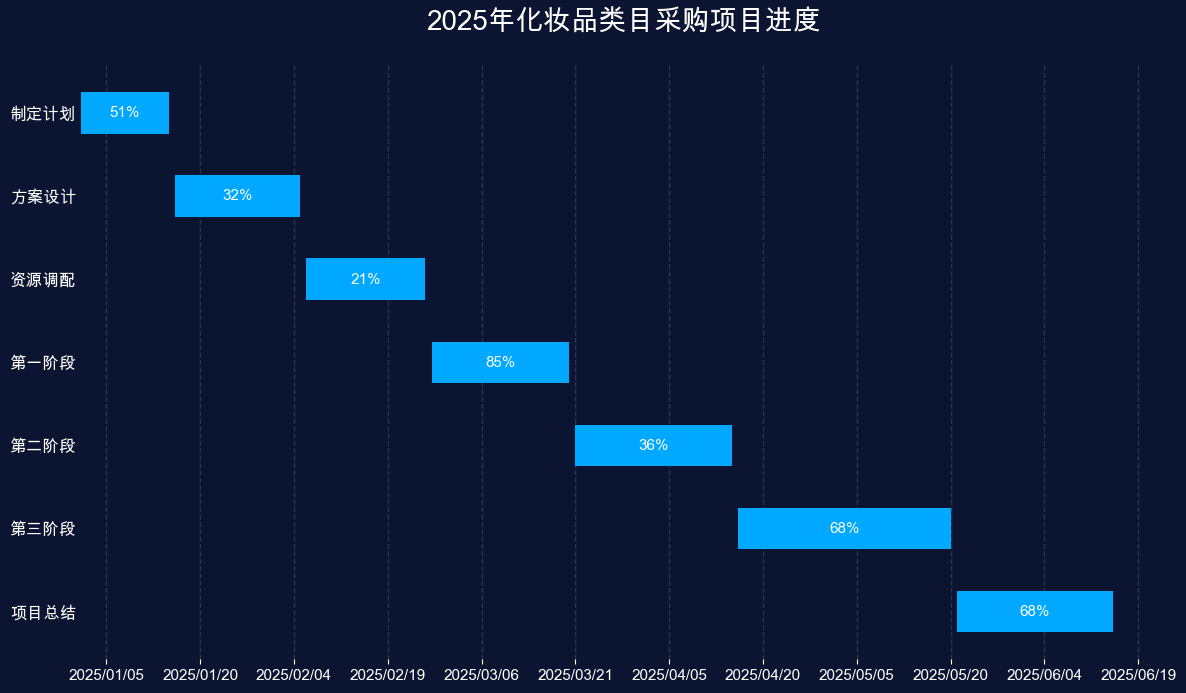

In [ ]:
tasks = [
    ("制定计划", "2025-01-01", "2025-01-15", 51),
    ("方案设计", "2025-01-16", "2025-02-05", 32),
    ("资源调配", "2025-02-06", "2025-02-25", 21),
    ("第一阶段", "2025-02-26", "2025-03-20", 85),
    ("第二阶段", "2025-03-21", "2025-04-15", 36),
    ("第三阶段", "2025-04-16", "2025-05-20", 68),
    ("项目总结", "2025-05-21", "2025-06-15", 68),
 ]

task_names = [t[0] for t in tasks]
start_dates = [datetime.strptime(t[1], "%Y-%m-%d") for t in tasks]
end_dates = [datetime.strptime(t[2], "%Y-%m-%d") for t in tasks]
percents = [t[3] for t in tasks]
durations = [(e - s).days for s, e in zip(start_dates, end_dates)]
y_pos = range(len(tasks))

bg_color = "#0b1430"
bar_color = "#00A8FF"
grid_color = "#3b4a6a"

fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

for y, start, dur, p in zip(y_pos, start_dates, durations, percents):
    ax.barh(
        y,
        dur,
        left=start,
        height=0.5,
        color=bar_color,
        edgecolor=bar_color,
        linewidth=0,
        zorder=3,
    )
    mid = start + (dur / 2) * mdates.num2timedelta(1)
    ax.text(
        mid,
        y,
        f"{p}%",
        color="white",
        fontsize=11,
        fontweight="bold",
        ha="center",
        va="center",
    )

ax.set_yticks(list(y_pos))
ax.set_yticklabels(task_names, fontsize=12, color="white")

ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m/%d"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", fontsize=11, color="white")

for tick in ax.get_xticks():
    ax.axvline(
        x=mdates.num2date(tick),
        color=grid_color,
        linestyle="--",
        linewidth=1,
        alpha=0.6,
        zorder=1,
    )

ax.invert_yaxis()
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", colors="white")
for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(
    0.5,
    1.06,
    "2025年化妆品类目采购项目进度",
    transform=ax.transAxes,
    fontsize=20,
    fontweight="bold",
    ha="center",
    color="white",
)

plt.tight_layout()
plt.show()

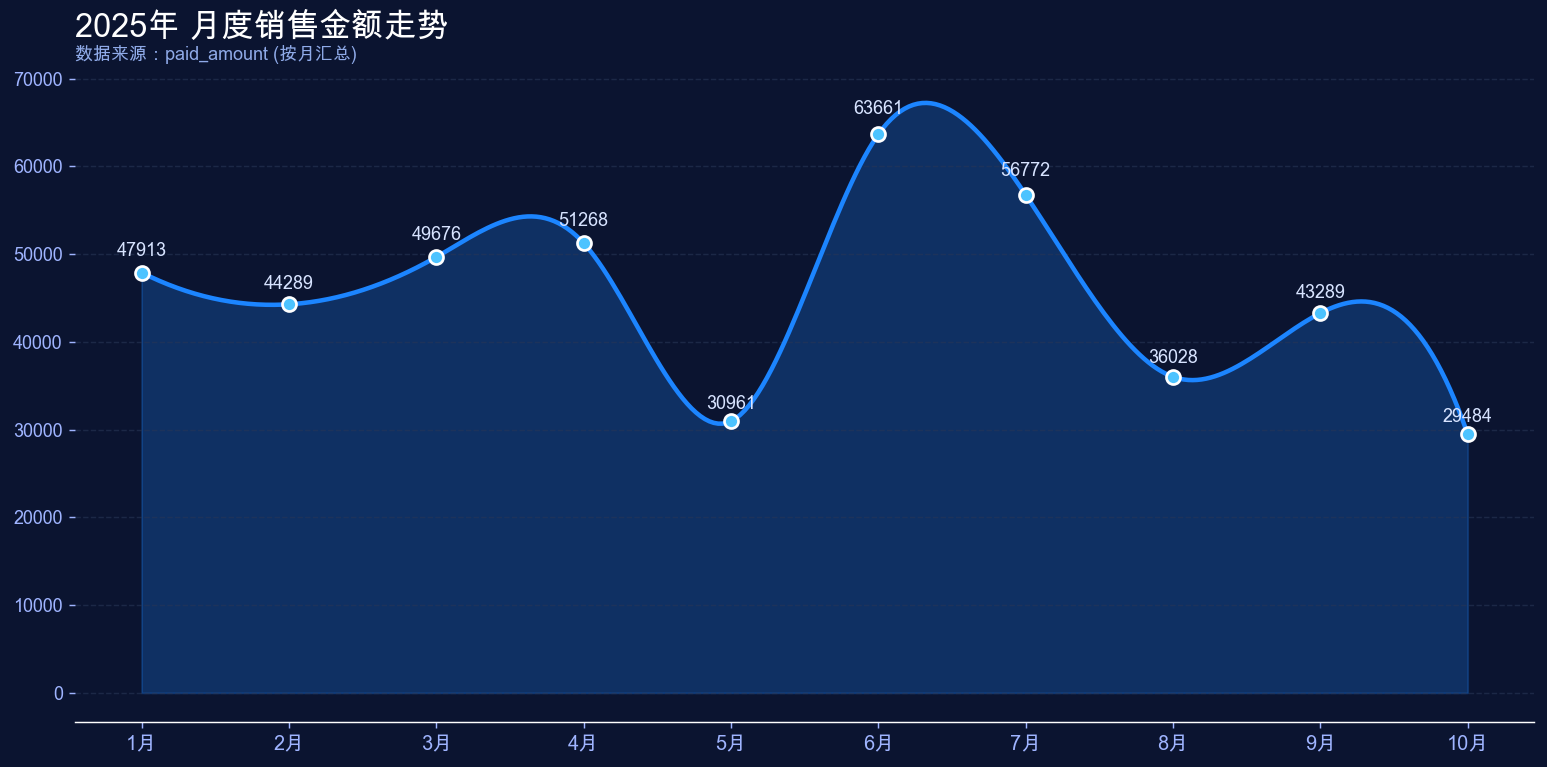

In [ ]:
date_col = PAYMENT_DATE_COL
amount_col = AMOUNT_COL

df_line = df.dropna(subset=[date_col]).copy()
df_2025 = df_line[df_line[date_col].dt.year == 2025].copy()
monthly = df_2025.groupby(df_2025[date_col].dt.month)[amount_col].sum().reset_index()
monthly.columns = ['month', 'amount']
monthly = monthly.sort_values('month')

max_month = monthly['month'].max()
all_months = pd.DataFrame({'month': range(1, int(max_month) + 1)})
monthly = pd.merge(all_months, monthly, on='month', how='left').fillna(0)

if len(monthly) >= 3:
    x = monthly['month'].values
    y = monthly['amount'].values
    x_new = np.linspace(x.min(), x.max(), 300)
    k_val = 3 if len(monthly) > 3 else 2
    spl = make_interp_spline(x, y, k=k_val)
    y_smooth = np.maximum(spl(x_new), 0)
else:
    x_new = monthly['month'].values
    y_smooth = monthly['amount'].values

plt.close('all')
plt.style.use('dark_background')
bg_color = '#0b1430'
line_color = '#1c85ff'
area_color = '#1c85ff'
dot_color = '#4cc3ff'
grid_color = '#283656'

fig, ax = plt.subplots(figsize=(12, 6), dpi=130)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

ax.fill_between(x_new, y_smooth, 0, color=area_color, alpha=0.25, zorder=1)
ax.plot(x_new, y_smooth, color=line_color, linewidth=2.5, zorder=2)
ax.scatter(monthly['month'], monthly['amount'], color=dot_color, s=60, zorder=3, edgecolors='white', linewidth=1.5)
for _, row in monthly.iterrows():
    ax.text(row['month'], row['amount'] * 1.03, f"{row['amount']:.0f}", color='#d7e3ff', fontsize=10, ha='center', va='bottom', fontweight='bold')

ax.set_xticks(monthly['month'])
ax.set_xticklabels([f"{int(m)}月" for m in monthly['month']])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', color=grid_color, linestyle='--', linewidth=0.8, alpha=0.6)
ax.tick_params(axis='x', colors='#9fb4ff', labelsize=11)
ax.tick_params(axis='y', colors='#9fb4ff', labelsize=10)

ax.set_title('2025年 月度销售金额走势', fontsize=18, color='white', pad=20, loc='left')
ax.text(0, 1.02, f"数据来源：{amount_col} (按月汇总)", transform=ax.transAxes, color='#8faae8', fontsize=10)

plt.tight_layout()
plt.show()

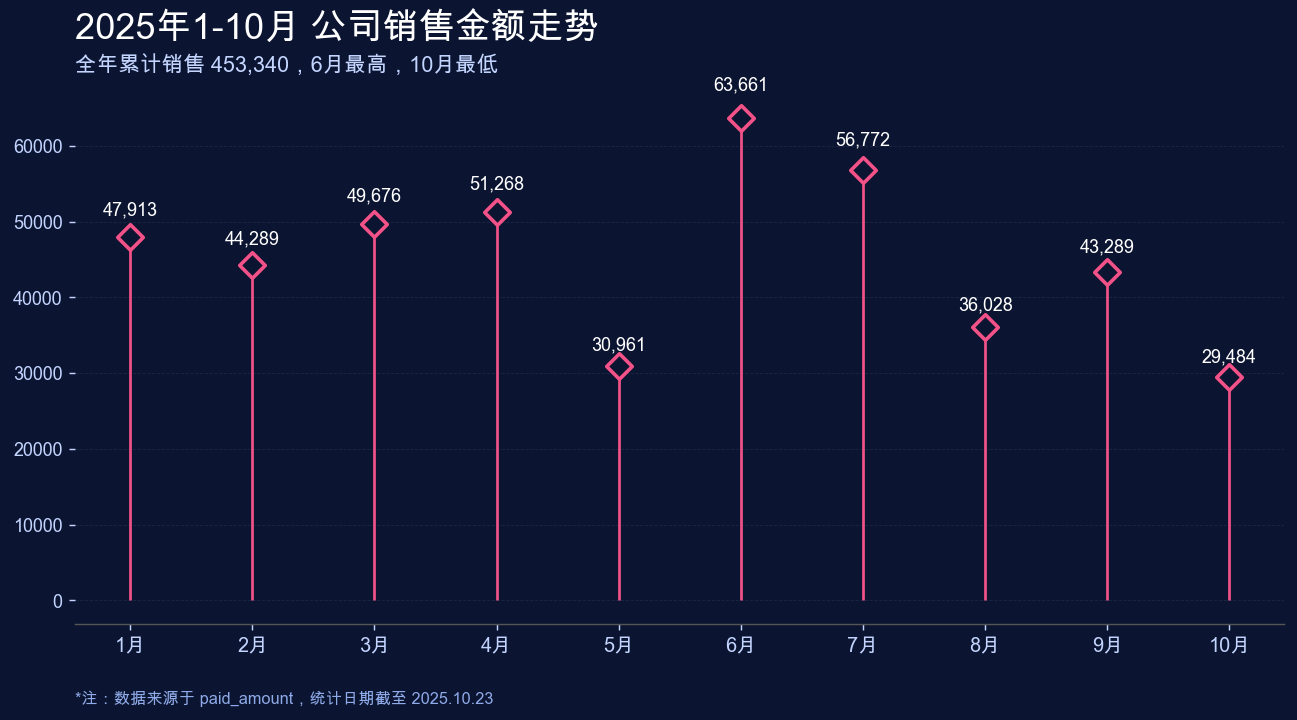

In [ ]:
date_col = PAYMENT_DATE_COL
amount_col = AMOUNT_COL

df_line = df.dropna(subset=[date_col]).copy()
df_2025 = df_line[df_line[date_col].dt.year == 2025].copy()
monthly = df_2025.groupby(df_2025[date_col].dt.month)[amount_col].sum().reset_index()
monthly.columns = ['month', 'amount']
monthly = monthly.sort_values('month')

max_month = monthly['month'].max()
all_months = pd.DataFrame({'month': range(1, int(max_month) + 1)})
monthly = pd.merge(all_months, monthly, on='month', how='left').fillna(0)

total_sales = monthly['amount'].sum()
max_month_row = monthly.loc[monthly['amount'].idxmax()]
min_month_row = monthly.loc[monthly['amount'].idxmin()]

plt.close('all')
plt.style.use('dark_background')
bg_color = '#0b1430'
stem_color = '#f25287'
text_color = '#ffffff'
grid_color = '#283656'

fig, ax = plt.subplots(figsize=(12, 6), dpi=130)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

ax.vlines(x=monthly['month'], ymin=0, ymax=monthly['amount'], color=stem_color, linewidth=1.5, zorder=2)
ax.scatter(monthly['month'], monthly['amount'], s=100, marker='D', facecolor=bg_color, edgecolors=stem_color, linewidth=2, zorder=3)
for _, row in monthly.iterrows():
    ax.text(row['month'], row['amount'] * 1.05, f"{row['amount']:,.0f}", color=text_color, fontsize=10, ha='center', va='bottom')

ax.set_xticks(monthly['month'])
ax.set_xticklabels([f"{int(m)}月" for m in monthly['month']])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#555555')
ax.grid(axis='y', color=grid_color, linestyle='--', linewidth=0.5, alpha=0.5)
ax.tick_params(axis='x', colors='#c3d4ff', labelsize=11)
ax.tick_params(axis='y', colors='#c3d4ff', labelsize=10)

title = '2025年1-{}月 公司销售金额走势'.format(int(max_month))
subtitle = f"全年累计销售 {total_sales:,.0f}，{int(max_month_row['month'])}月最高，{int(min_month_row['month'])}月最低"
note = f"*注：数据来源于 {amount_col}，统计日期截至 {NOTE_DATE:%Y.%m.%d}"

ax.set_title(title, fontsize=20, color='white', pad=30, loc='left', fontweight='bold')
ax.text(0, 1.04, subtitle, transform=ax.transAxes, color='#c3d4ff', fontsize=12, ha='left')
ax.text(0, -0.15, note, transform=ax.transAxes, color='#8faae8', fontsize=9, ha='left')
plt.subplots_adjust(bottom=0.2)
plt.show()

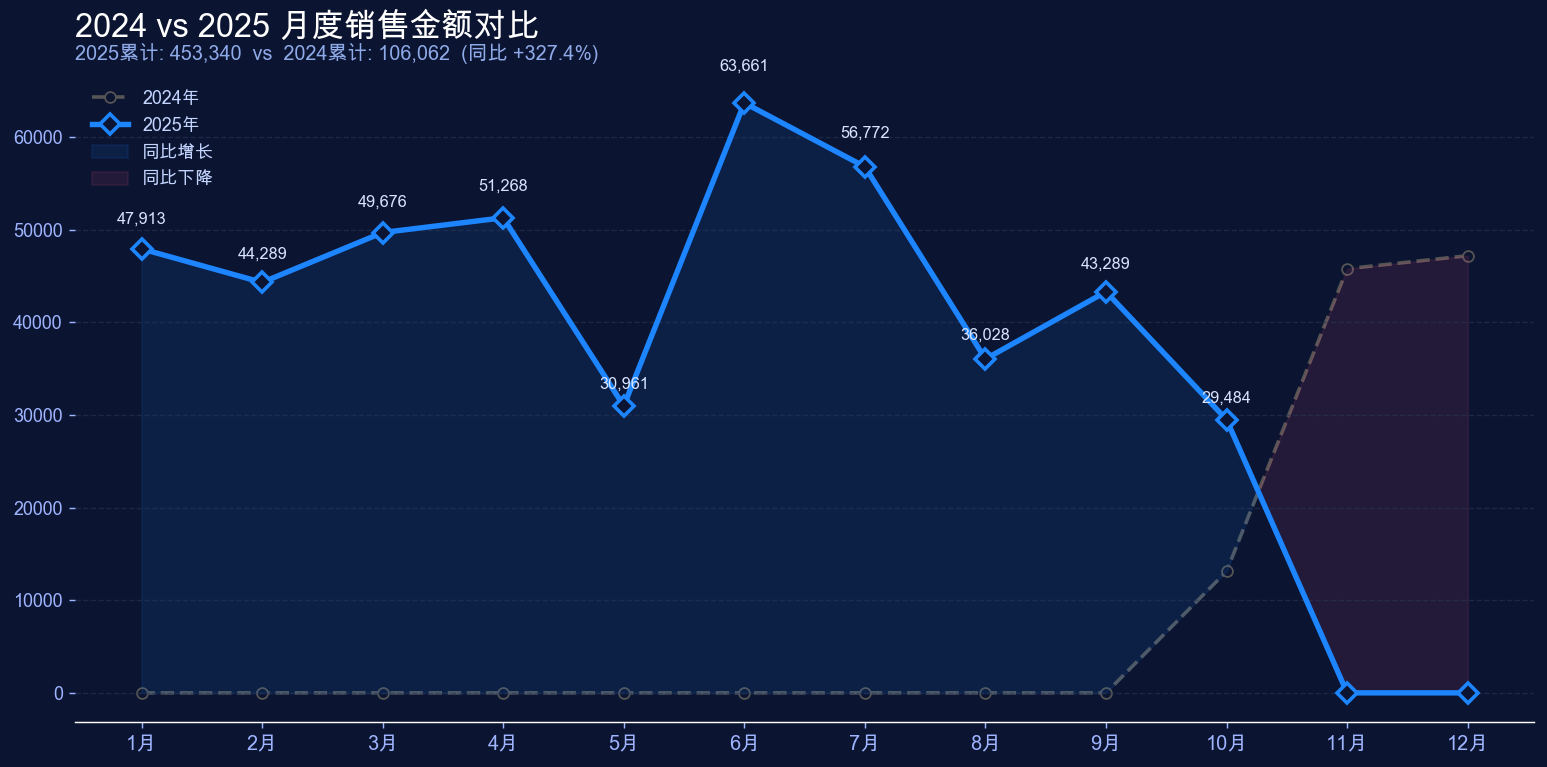

In [ ]:
date_col = PAYMENT_DATE_COL
amount_col = AMOUNT_COL

df_line = df.dropna(subset=[date_col]).copy()
df_line['year'] = df_line[date_col].dt.year

df_2024 = df_line[df_line['year'] == 2024].copy()
df_2025 = df_line[df_line['year'] == 2025].copy()

monthly_2024 = df_2024.groupby(df_2024[date_col].dt.month)[amount_col].sum().reset_index()
monthly_2024.columns = ['month', 'amount_2024']
monthly_2025 = df_2025.groupby(df_2025[date_col].dt.month)[amount_col].sum().reset_index()
monthly_2025.columns = ['month', 'amount_2025']

all_months = pd.DataFrame({'month': range(1, 13)})
comp_df = pd.merge(all_months, monthly_2024, on='month', how='left')
comp_df = pd.merge(comp_df, monthly_2025, on='month', how='left')
comp_df = comp_df.fillna(0)

plt.close('all')
plt.style.use('dark_background')
bg_color = '#0b1430'
color_2024 = '#555555'
color_2025 = '#1c85ff'
grid_color = '#283656'

fig, ax = plt.subplots(figsize=(12, 6), dpi=130)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

ax.plot(comp_df['month'], comp_df['amount_2024'], color=color_2024, linestyle='--', linewidth=2, marker='o', markersize=6, markerfacecolor=bg_color, markeredgecolor=color_2024, label='2024年', zorder=1)
ax.plot(comp_df['month'], comp_df['amount_2025'], color=color_2025, linestyle='-', linewidth=3, marker='D', markersize=8, markerfacecolor=bg_color, markeredgecolor=color_2025, markeredgewidth=2, label='2025年', zorder=2)
ax.fill_between(comp_df['month'], comp_df['amount_2024'], comp_df['amount_2025'], where=(comp_df['amount_2025'] >= comp_df['amount_2024']), interpolate=True, color=color_2025, alpha=0.1, label='同比增长')
ax.fill_between(comp_df['month'], comp_df['amount_2024'], comp_df['amount_2025'], where=(comp_df['amount_2025'] < comp_df['amount_2024']), interpolate=True, color='#f25287', alpha=0.1, label='同比下降')

for _, row in comp_df.iterrows():
    if row['amount_2025'] > 0:
        ax.text(row['month'], row['amount_2025'] * 1.05, f"{row['amount_2025']:,.0f}", color='#d7e3ff', fontsize=9, ha='center', va='bottom', fontweight='bold')

ax.set_xticks(comp_df['month'])
ax.set_xticklabels([f"{int(m)}月" for m in comp_df['month']])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', color=grid_color, linestyle='--', linewidth=0.8, alpha=0.6)
ax.tick_params(axis='x', colors='#9fb4ff', labelsize=11)
ax.tick_params(axis='y', colors='#9fb4ff', labelsize=10)

legend = ax.legend(loc='upper left', frameon=False, fontsize=10)
for text in legend.get_texts():
    text.set_color('#c3d4ff')

total_2024 = comp_df['amount_2024'].sum()
total_2025 = comp_df['amount_2025'].sum()
diff_pct = (total_2025 - total_2024) / total_2024 * 100 if total_2024 != 0 else 0
diff_str = f"+{diff_pct:.1f}%" if diff_pct > 0 else f"{diff_pct:.1f}%"

ax.set_title('2024 vs 2025 月度销售金额对比', fontsize=18, color='white', pad=20, loc='left')
ax.text(0, 1.02, f"2025累计: {total_2025:,.0f}  vs  2024累计: {total_2024:,.0f}  (同比 {diff_str})", transform=ax.transAxes, color='#8faae8', fontsize=11)

plt.tight_layout()
plt.show()

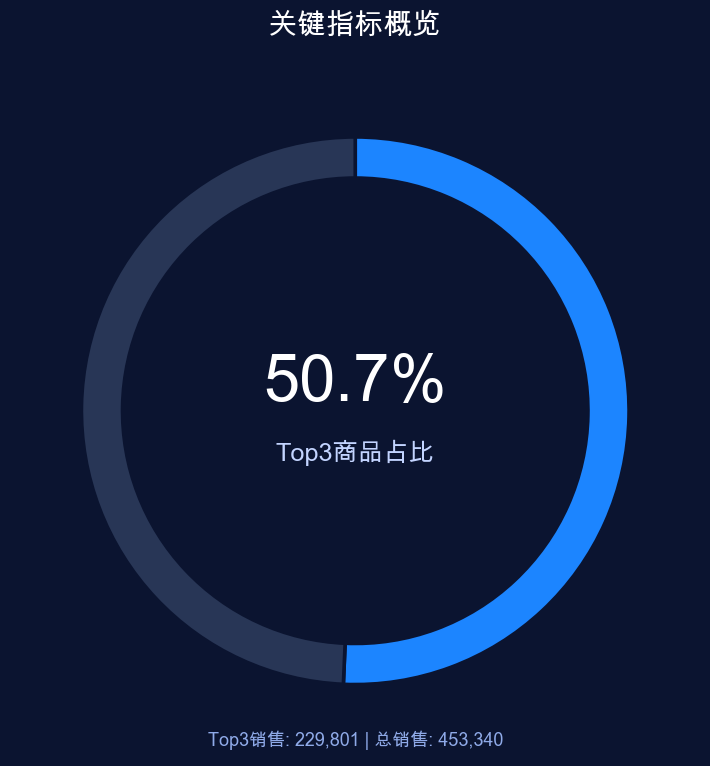

In [ ]:
date_col = PAYMENT_DATE_COL
amount_col = AMOUNT_COL
cost_col = COST_COL

df_donut = df.dropna(subset=[date_col]).copy()
df_2025 = df_donut[df_donut[date_col].dt.year == 2025].copy()
total_sales_2025 = df_2025[amount_col].sum()
if cost_col:
    total_cost_2025 = df_2025[cost_col].sum()
    total_profit_2025 = total_sales_2025 - total_cost_2025
    margin_pct = total_profit_2025 / total_sales_2025 if total_sales_2025 != 0 else 0
    label_text = "2025年利润率"
    sub_text = f"销售: {total_sales_2025:,.0f} | 利润: {total_profit_2025:,.0f}"
else:
    top_3_sales = df_2025.groupby('product_name')[amount_col].sum().nlargest(3).sum()
    margin_pct = top_3_sales / total_sales_2025 if total_sales_2025 != 0 else 0
    label_text = "Top3商品占比"
    sub_text = f"Top3销售: {top_3_sales:,.0f} | 总销售: {total_sales_2025:,.0f}"

plt.close('all')
plt.style.use('dark_background')
bg_color = '#0b1430'
active_color = '#1c85ff'
base_color = '#283656'

fig, ax = plt.subplots(figsize=(6, 6), dpi=130)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

sizes = [margin_pct, 1 - margin_pct]
colors = [active_color, base_color]

ax.pie(sizes, colors=colors, startangle=90, counterclock=False,
       wedgeprops={'width': 0.15, 'edgecolor': bg_color, 'linewidth': 2})
ax.text(0, 0.1, f"{margin_pct:.1%}", ha='center', va='center', fontsize=36, color='white', fontweight='bold')
ax.text(0, -0.15, label_text, ha='center', va='center', fontsize=14, color='#c3d4ff')
ax.text(0, -1.2, sub_text, ha='center', va='center', fontsize=10, color='#8faae8')
ax.set_title('关键指标概览', fontsize=16, color='white', pad=20)

plt.tight_layout()
plt.show()

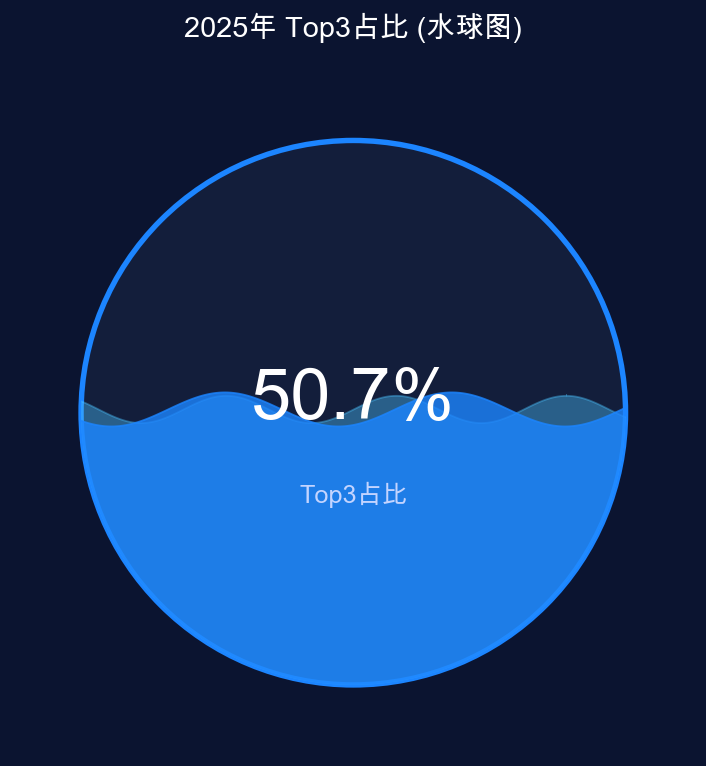

In [ ]:
date_col = PAYMENT_DATE_COL
amount_col = AMOUNT_COL
cost_col = COST_COL

df_liquid = df.dropna(subset=[date_col]).copy()
df_2025 = df_liquid[df_liquid[date_col].dt.year == 2025].copy()
total_sales_2025 = df_2025[amount_col].sum()
if cost_col:
    total_cost_2025 = df_2025[cost_col].sum()
    total_profit_2025 = total_sales_2025 - total_cost_2025
    pct = total_profit_2025 / total_sales_2025 if total_sales_2025 != 0 else 0
    label_text = "利润率"
elif 'product_name' in df_2025.columns:
    top_3_sales = df_2025.groupby('product_name')[amount_col].sum().nlargest(3).sum()
    pct = top_3_sales / total_sales_2025 if total_sales_2025 != 0 else 0
    label_text = "Top3占比"
else:
    pct = 0.0
    label_text = "占比"

display_pct = np.clip(pct, 0.0, 1.0)

plt.close('all')
plt.style.use('dark_background')
bg_color = '#0b1430'
water_color = '#1c85ff'
water_color_light = '#4cc3ff'
container_color = '#283656'

fig, ax = plt.subplots(figsize=(6, 6), dpi=130)
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')

circle_center = (0.5, 0.5)
radius = 0.4
circle_bg = Circle(circle_center, radius, color=container_color, alpha=0.3)
ax.add_patch(circle_bg)
circle_border = Circle(circle_center, radius, color=water_color, fill=False, linewidth=3)
ax.add_patch(circle_border)

x = np.linspace(0, 1, 500)
water_level = 0.5 - radius + (2 * radius * display_pct)
amplitude1 = 0.02
frequency1 = 8
y_wave1 = water_level + amplitude1 * np.sin(frequency1 * x * np.pi)

amplitude2 = 0.025
frequency2 = 6
phase2 = 2
y_wave2 = water_level + amplitude2 * np.sin(frequency2 * x * np.pi + phase2)

clip_circle = Circle(circle_center, radius, transform=ax.transData)
wave_poly1 = ax.fill_between(x, 0, y_wave1, color=water_color_light, alpha=0.4)
wave_poly1.set_clip_path(clip_circle)
wave_poly2 = ax.fill_between(x, 0, y_wave2, color=water_color, alpha=0.8)
wave_poly2.set_clip_path(clip_circle)

ax.text(0.5, 0.52, f"{pct:.1%}", ha='center', va='center', fontsize=40, color='white', fontweight='bold', zorder=10)
ax.text(0.5, 0.38, label_text, ha='center', va='center', fontsize=14, color='#c3d4ff', zorder=10)
ax.set_title(f'2025年 {label_text} (水球图)', fontsize=16, color='white', pad=20)

plt.tight_layout()
plt.show()

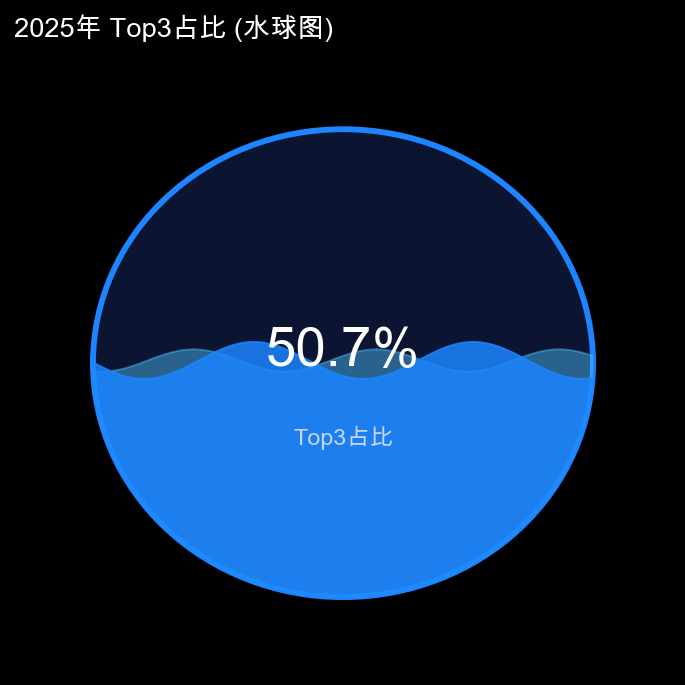

In [ ]:
date_col = PAYMENT_DATE_COL
amount_col = AMOUNT_COL
cost_col = COST_COL

df_w = df.dropna(subset=[date_col]).copy()
df_2025 = df_w[df_w[date_col].dt.year == 2025].copy()
total_sales = df_2025[amount_col].sum()
if cost_col:
    total_cost = df_2025[cost_col].sum()
    total_profit = total_sales - total_cost
    pct = total_profit / total_sales if total_sales != 0 else 0.0
    label = '利润率'
elif 'product_name' in df_2025.columns:
    top3 = df_2025.groupby('product_name')[amount_col].sum().nlargest(3).sum()
    pct = top3 / total_sales if total_sales != 0 else 0.0
    label = 'Top3占比'
else:
    pct = 0.0
    label = '占比'

display_pct = float(np.clip(pct, 0.0, 1.0))

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(5,5), dpi=140)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis('off')

center=(0.5,0.5)
radius=0.38
container = Circle(center, radius, facecolor='#0b1430', edgecolor='#1c85ff', linewidth=3, zorder=1)
ax.add_patch(container)

x = np.linspace(0,1,600)
water_level = 0.5 - radius + (2*radius*display_pct)
amp = 0.03
freq = 3.0
phase = 1.0
y_wave = water_level + amp * np.sin(2*np.pi*freq*x + phase)

wave = ax.fill_between(x, 0, y_wave, color='#1c85ff', alpha=0.85, zorder=3)
wave.set_clip_path(container)
y_wave2 = water_level + (amp*0.6) * np.sin(2*np.pi*(freq*1.2)*x + phase + 0.7)
wave2 = ax.fill_between(x, 0, y_wave2, color='#4cc3ff', alpha=0.45, zorder=2)
wave2.set_clip_path(container)

ax.text(0.5, 0.52, f"{pct:.1%}", ha='center', va='center', fontsize=28, color='white', fontweight='bold', zorder=10)
ax.text(0.5, 0.38, label, ha='center', va='center', fontsize=12, color='#c3d4ff', zorder=10)
ax.set_title(f'2025年 {label} (水球图)', fontsize=14, color='white', pad=10, loc='left')

plt.tight_layout()
plt.show()

/var/folders/k7/n7_ph9fs26558rthw4gbgc8m0000gn/T/ipykernel_41714/3890306815.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_2025.groupby('price_bucket')[amount_col].sum().reset_index()


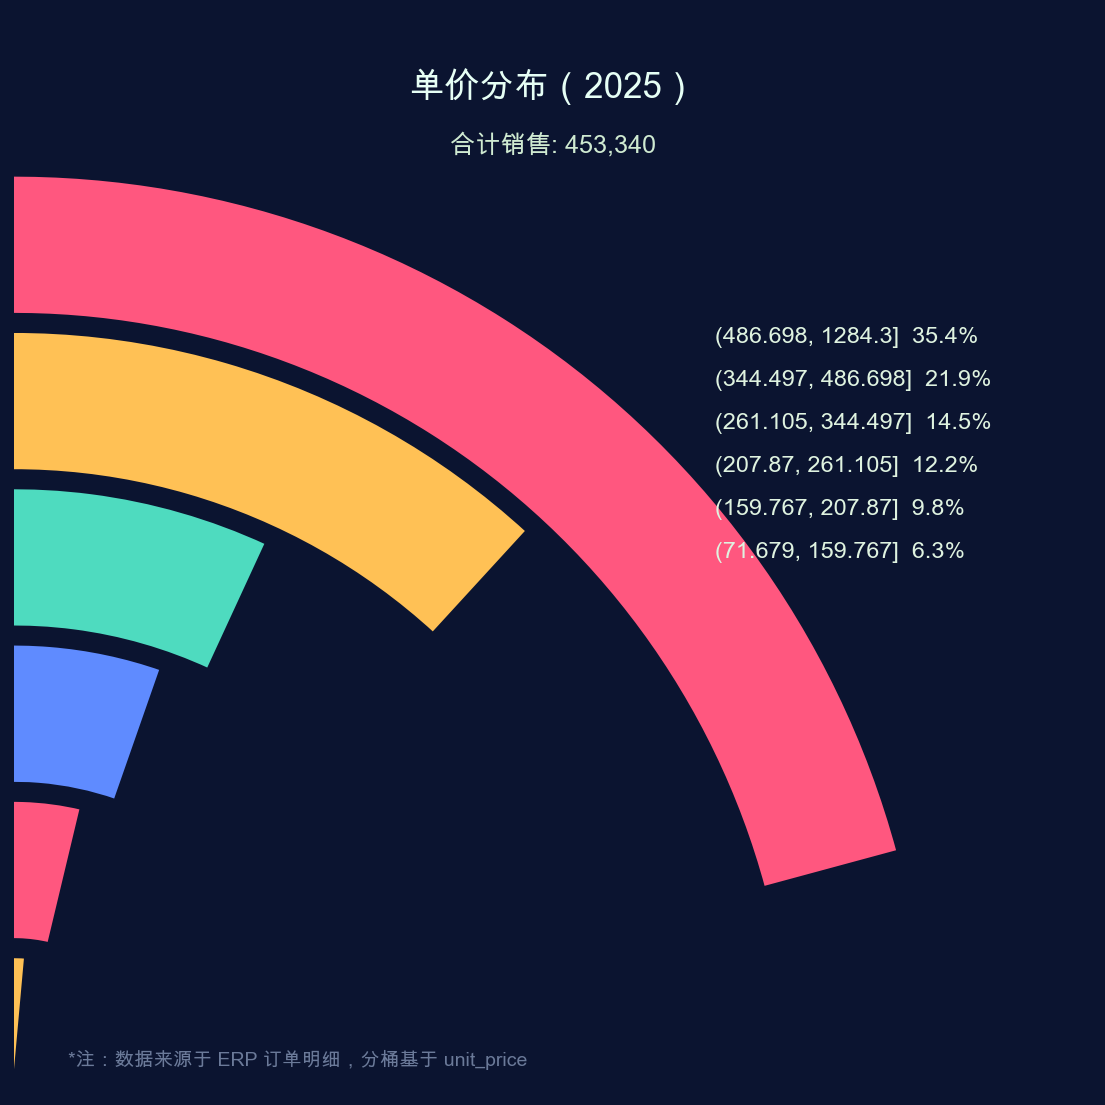

In [ ]:
date_col = PAYMENT_DATE_COL
amount_col = AMOUNT_COL

df_jade = df.dropna(subset=[date_col]).copy()
if 'unit_price' in df_jade.columns:
    df_jade['unit_price_calc'] = pd.to_numeric(df_jade['unit_price'], errors='coerce')
elif QUANTITY_COL:
    df_jade['unit_price_calc'] = df_jade[amount_col] / df_jade[QUANTITY_COL].replace({0:np.nan})
else:
    df_jade['unit_price_calc'] = df_jade[amount_col]

df_2025 = df_jade[df_jade[date_col].dt.year == 2025].copy()
df_2025 = df_2025.dropna(subset=['unit_price_calc'])
n_bins = 6
price_series = df_2025['unit_price_calc']
if price_series.nunique() >= n_bins:
    df_2025['price_bucket'] = pd.qcut(price_series, q=n_bins, duplicates='drop')
else:
    bins = np.linspace(price_series.min(), price_series.max(), n_bins + 1)
    df_2025['price_bucket'] = pd.cut(price_series, bins=bins, include_lowest=True)

agg = df_2025.groupby('price_bucket')[amount_col].sum().reset_index()
agg = agg.sort_values(amount_col, ascending=False)
labels = agg['price_bucket'].astype(str).tolist()
values = agg[amount_col].astype(float).to_numpy()
if values.sum() == 0:
    values = np.ones_like(values)
shares = values / values.sum()
percentages = [f"{s*100:.1f}%" for s in shares]

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 8), dpi=140)
bg_color = '#0b1430'
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

outer_r = 0.85
thickness = 0.13
gap = 0.015
n = len(shares)
startangle_end = 100.0
max_arc_deg = 240.0
arc_degs = max_arc_deg * shares
base_colors = ['#ff577f', '#ffc155', '#4edbbf', '#5f8bff']
colors = [base_colors[i % len(base_colors)] for i in range(n)]
current_r = outer_r
for i in range(n):
    theta2 = startangle_end
    theta1 = startangle_end - arc_degs[i]
    w = Wedge(center=(0, 0), r=current_r, theta1=theta1, theta2=theta2,
              width=thickness, facecolor=colors[i], edgecolor=bg_color, linewidth=2.0, zorder=3)
    ax.add_patch(w)
    current_r -= (thickness + gap)

ax.text(0.5, 0.95, '单价分布（2025）', ha='center', va='top', fontsize=18, color='#e6fff5', fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.89, f"合计销售: {values.sum():,.0f}", ha='center', va='top', fontsize=13, color='#cfead1', transform=ax.transAxes)

legend_x = 0.65
legend_y_start = 0.70
legend_spacing = 0.04
for i, (lab, pct) in enumerate(zip(labels, percentages)):
    ax.text(legend_x, legend_y_start - i * legend_spacing, f"{lab}  {pct}", ha='left', va='center', fontsize=12, color='#dff3e0', transform=ax.transAxes)

ax.text(0.05, 0.02, '*注：数据来源于 ERP 订单明细，分桶基于 unit_price', ha='left', va='bottom', fontsize=10, color='#6b7a99', transform=ax.transAxes)
ax.set(aspect='equal')
ax.axis('off')
plt.tight_layout()
plt.show()

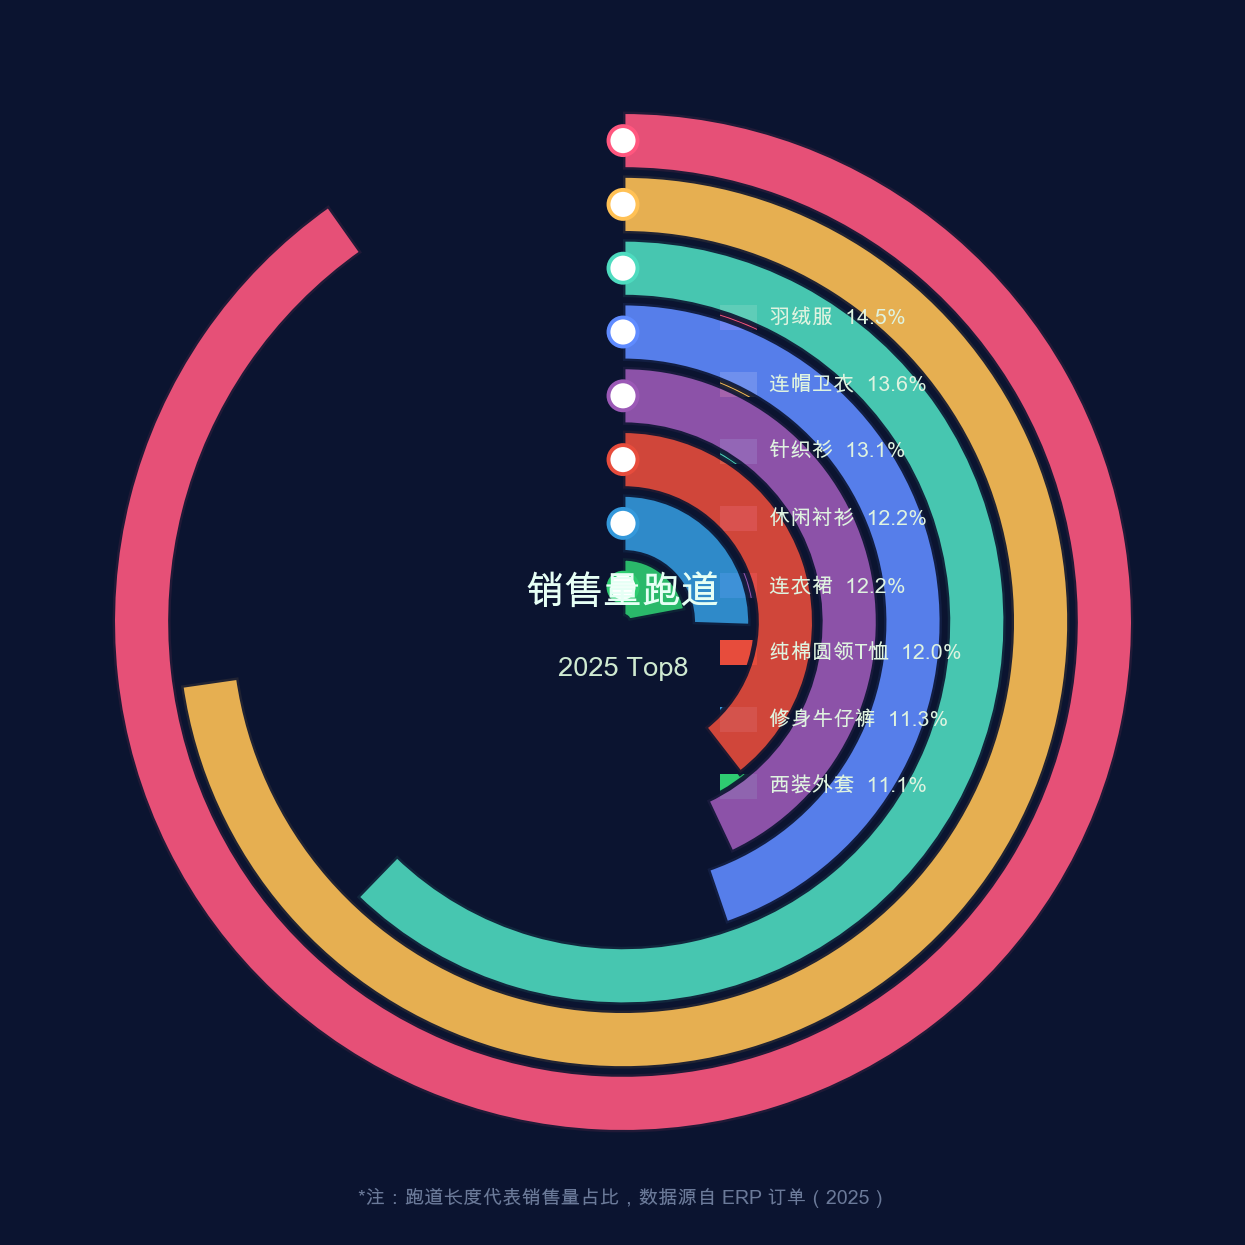

In [ ]:
date_col = PAYMENT_DATE_COL
measure_col = QUANTITY_COL or AMOUNT_COL
category_col = next((c for c in ['product_name', 'province', 'store_name', 'category'] if c in df.columns), None)
df_race = df.dropna(subset=[date_col]).copy()
df_2025 = df_race[df_race[date_col].dt.year == 2025].copy()
agg = df_2025.groupby(category_col, as_index=False)[measure_col].sum().rename(columns={measure_col: 'metric'})
agg = agg.sort_values('metric', ascending=False).head(8)
labels = agg[category_col].astype(str).tolist()
values = agg['metric'].astype(float).tolist()
values_arr = np.array(values, dtype=float)
if values_arr.sum() == 0:
    values_arr = np.ones_like(values_arr)
shares = values_arr / values_arr.sum()
percentages = [f"{s*100:.1f}%" for s in shares]
shares_amplified = shares * 4
if shares_amplified.sum() > 1:
    shares_amplified = shares_amplified / shares_amplified.sum()

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(9, 9), dpi=140)
bg_color = '#0b1430'
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

base_colors = ['#ff577f', '#ffc155', '#4edbbf', '#5f8bff', '#9b59b6', '#e74c3c', '#3498db', '#2ecc71']
colors = [base_colors[i % len(base_colors)] for i in range(len(shares))]

outer_r = 0.88
thickness = 0.10
gap = 0.01
max_arc_deg = 7200.0
startangle_end = 90.0
arc_degs = max_arc_deg * shares_amplified
current_r = outer_r
for i in range(len(shares)):
    theta2 = startangle_end
    theta1 = startangle_end - arc_degs[i]
    w = Wedge(center=(0, 0), r=current_r, theta1=theta1, theta2=theta2,
              width=thickness, facecolor=colors[i], edgecolor=bg_color, linewidth=2.5, alpha=0.9, zorder=3)
    ax.add_patch(w)
    end_angle_rad = np.deg2rad(theta2)
    end_x = (current_r - thickness/2) * np.cos(end_angle_rad)
    end_y = (current_r - thickness/2) * np.sin(end_angle_rad)
    marker = Circle((end_x, end_y), thickness/4, facecolor='white', edgecolor=colors[i], linewidth=2, zorder=5)
    ax.add_patch(marker)
    current_r -= (thickness + gap)

ax.text(0, 0.05, f'{ "销售量" if measure_col == QUANTITY_COL else "销售额" }跑道', ha='center', va='center', fontsize=20, color='#e6fff5', fontweight='bold', zorder=10)
ax.text(0, -0.08, '2025 Top8', ha='center', va='center', fontsize=14, color='#cfead1', zorder=10)

legend_x = 0.62
legend_y_start = 0.75
legend_spacing = 0.055
for i, (lab, pct) in enumerate(zip(labels, percentages)):
    display_lab = lab if len(lab) <= 12 else lab[:10] + '..'
    ax.text(legend_x, legend_y_start - i * legend_spacing, f"{display_lab}  {pct}", ha='left', va='center', fontsize=11, color='#dff3e0', transform=ax.transAxes)
    rect_x = legend_x - 0.04
    rect_y = legend_y_start - i * legend_spacing
    color_box = Rectangle((rect_x, rect_y - 0.01), 0.03, 0.02, transform=ax.transAxes, facecolor=colors[i], edgecolor='none', zorder=2)
    ax.add_patch(color_box)

ax.text(0.5, 0.02, f'*注：跑道长度代表{ "销售量" if measure_col == QUANTITY_COL else "销售额" }占比，数据源自 ERP 订单（2025）', ha='center', va='bottom', fontsize=10, color='#6b7a99', transform=ax.transAxes)
ax.set(aspect='equal')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.axis('off')
plt.tight_layout()
plt.show()

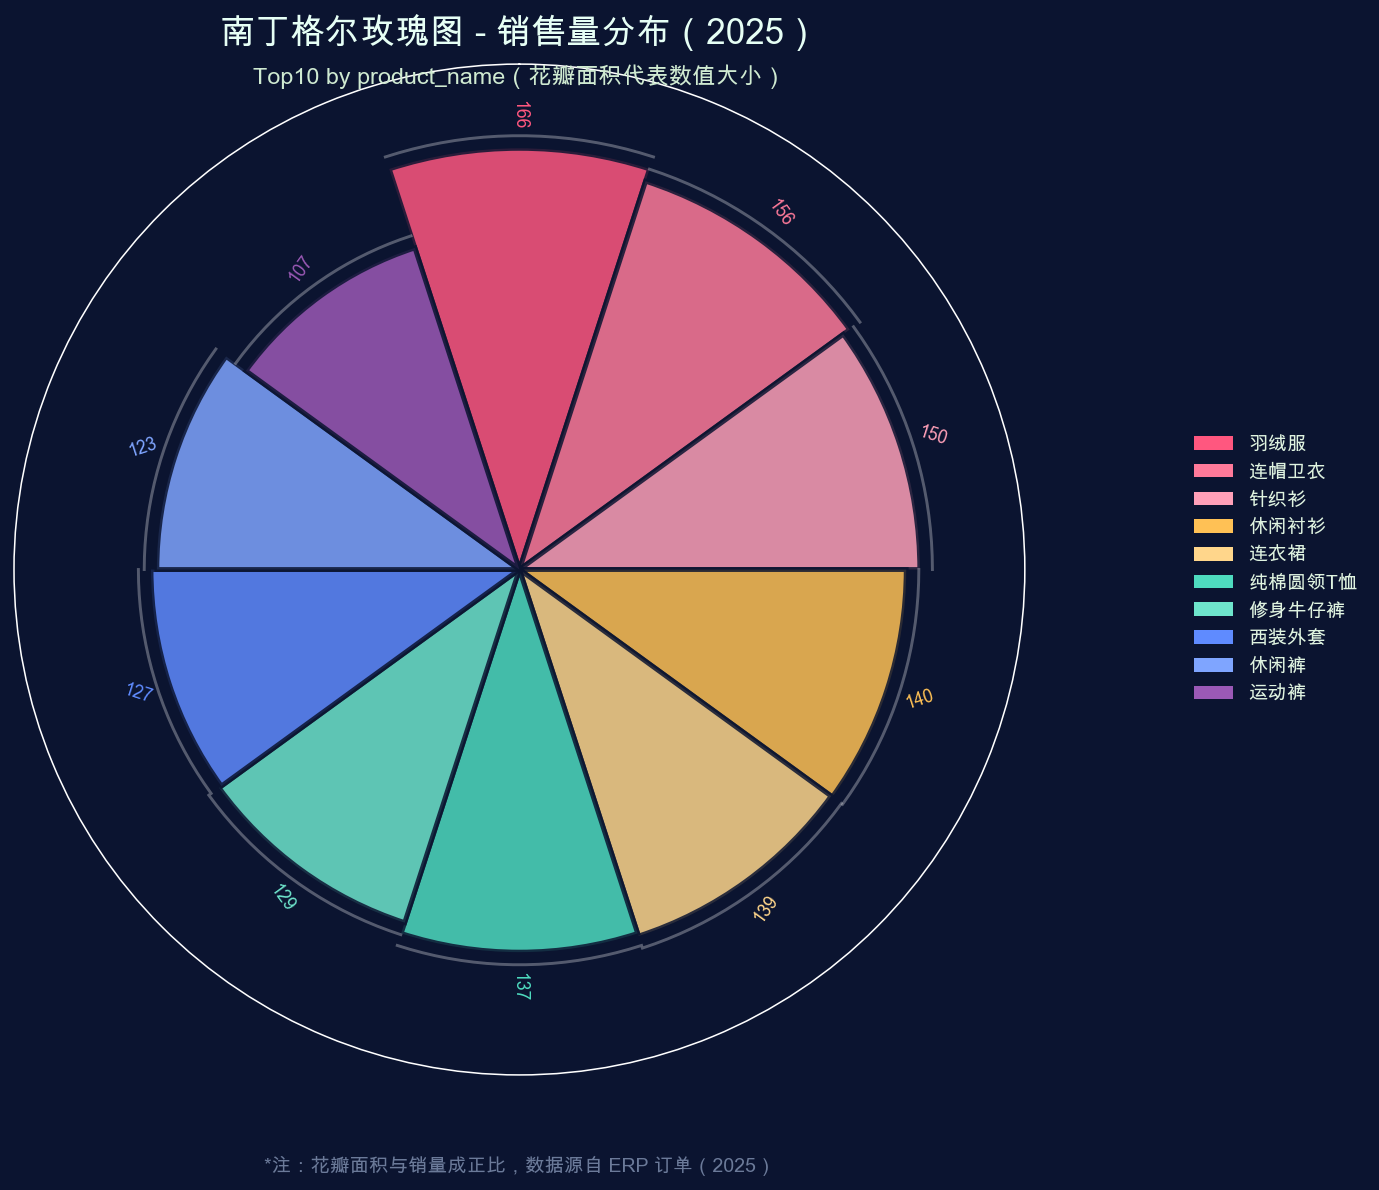

In [ ]:
date_col = PAYMENT_DATE_COL
value_col = QUANTITY_COL or AMOUNT_COL
category_col = next((c for c in ['product_name', 'province', 'store_name', 'category'] if c in df.columns), None)
df_rose = df.dropna(subset=[date_col]).copy()
df_2025 = df_rose[df_rose[date_col].dt.year == 2025].copy()
agg = df_2025.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
metric_name = '销售量' if value_col == QUANTITY_COL else '销售额'
agg = agg.sort_values('metric', ascending=False).head(12)
labels = agg[category_col].astype(str).tolist()
values = agg['metric'].astype(float).tolist()
if not values:
    raise ValueError('没有有效数据')

values_arr = np.array(values, dtype=float)
radii = np.sqrt(values_arr / values_arr.max())

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 10), dpi=140, subplot_kw=dict(projection='polar'))
bg_color = '#0b1430'
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

base_colors = ['#ff577f', '#ff7a9a', '#ffa0b8', '#ffc155', '#ffd68b', '#4edbbf', '#6ee5cc', '#5f8bff', '#7fa5ff', '#9b59b6', '#b07cc6', '#e74c3c']
colors = [base_colors[i % len(base_colors)] for i in range(len(values))]

theta = np.linspace(0, 2 * np.pi, len(values), endpoint=False)
width = 2 * np.pi / len(values)
bars = ax.bar(theta, radii, width=width, bottom=0.0, color=colors, edgecolor=bg_color, linewidth=2.5, alpha=0.85)
for t, r in zip(theta, radii):
    highlight_r = r + 0.03
    highlight_theta = np.linspace(t - width/2, t + width/2, 20)
    ax.plot(highlight_theta, [highlight_r]*len(highlight_theta), color='white', alpha=0.3, linewidth=1.5, zorder=5)

for t, r, val, lab, color in zip(theta, radii, values, labels, colors):
    label_r = r + 0.08
    angle = np.degrees(t)
    rotation = angle if angle < 180 else angle - 180
    ax.text(t, label_r, f'{val:,.0f}', ha='center', va='center', fontsize=9, color=color, fontweight='bold', rotation=rotation - 90, rotation_mode='anchor')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_ylim(0, 1.2)
ax.set_yticks([])
ax.grid(False)
ax.set_xticks(theta)
ax.set_xticklabels([])

ax.text(0.5, 1.05, f'南丁格尔玫瑰图 - {metric_name}分布（2025）', ha='center', va='top', fontsize=18, color='#e6fff5', fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 1.0, f'Top{len(labels)} by {category_col}（花瓣面积代表数值大小）', ha='center', va='top', fontsize=12, color='#cfead1', transform=ax.transAxes)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='none') for i in range(len(labels))]
legend_labels = [lab if len(lab) <= 15 else lab[:13]+'..' for lab in labels]
ax.legend(legend_elements, legend_labels, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=False, fontsize=10, labelcolor='#dff3e0')
ax.text(0.5, -0.08, '*注：花瓣面积与销量成正比，数据源自 ERP 订单（2025）', ha='center', va='top', fontsize=10, color='#6b7a99', transform=ax.transAxes)

plt.tight_layout()
plt.show()

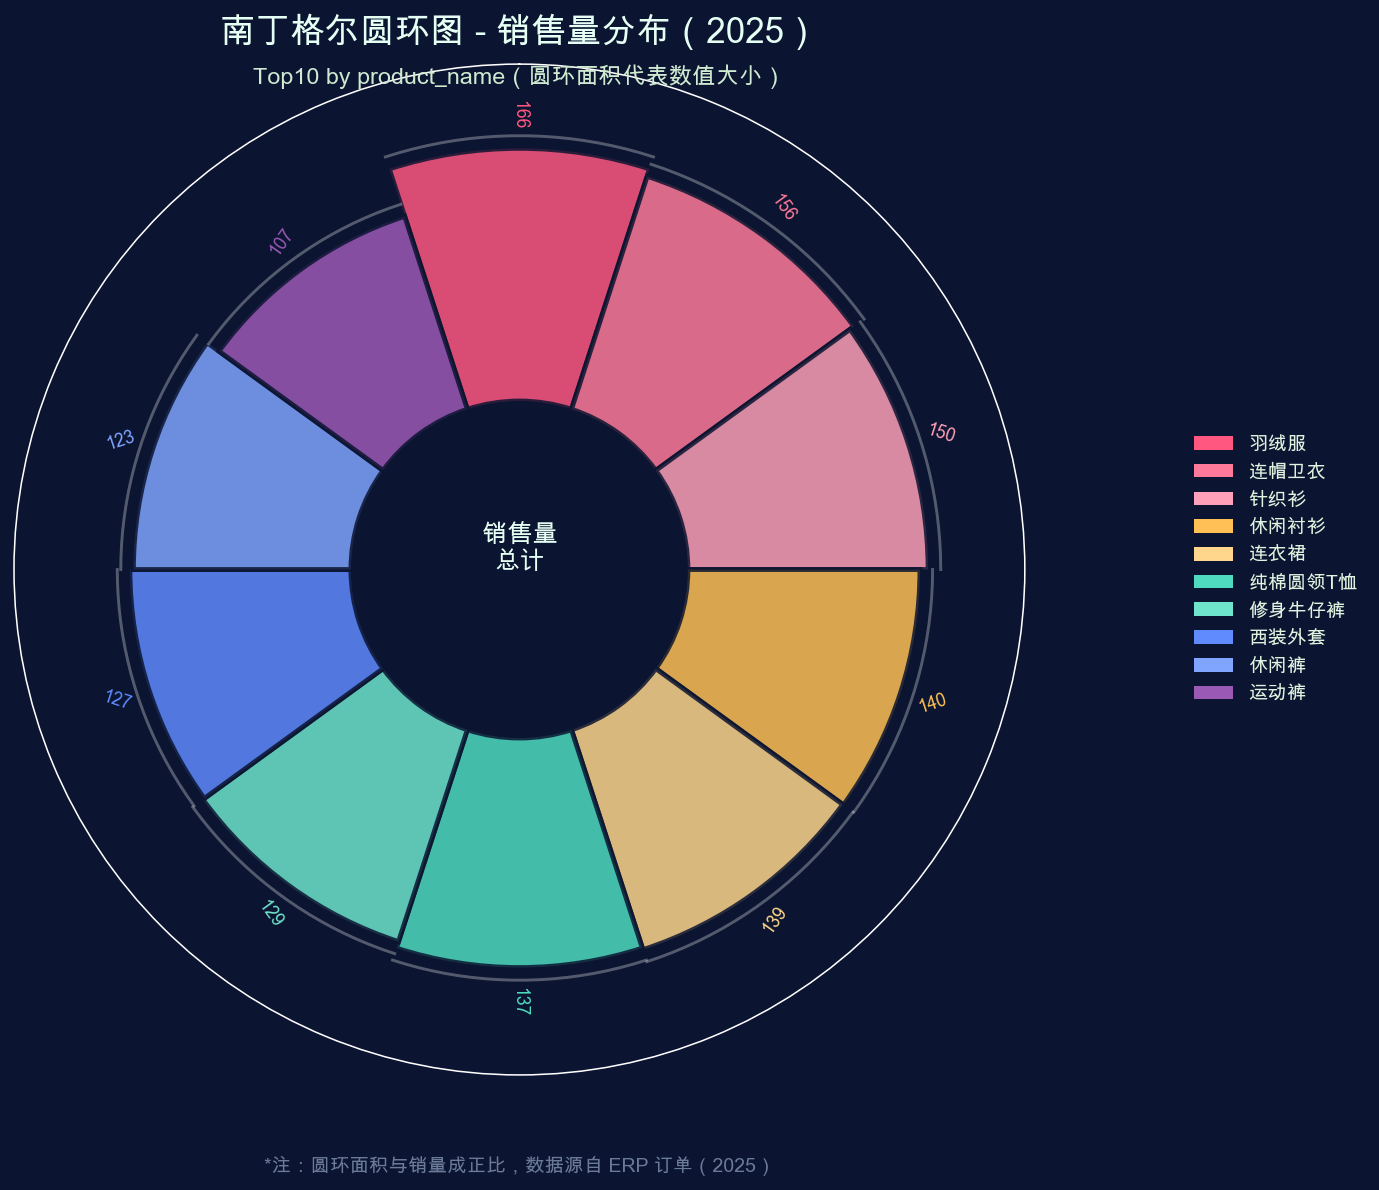

In [ ]:
date_col = PAYMENT_DATE_COL
value_col = QUANTITY_COL or AMOUNT_COL
category_col = next((c for c in ['product_name', 'province', 'store_name', 'category'] if c in df.columns), None)
df_rose = df.dropna(subset=[date_col]).copy()
df_2025 = df_rose[df_rose[date_col].dt.year == 2025].copy()
agg = df_2025.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
metric_name = '销售量' if value_col == QUANTITY_COL else '销售额'
agg = agg.sort_values('metric', ascending=False).head(12)
labels = agg[category_col].astype(str).tolist()
values = agg['metric'].astype(float).tolist()
if not values:
    raise ValueError('没有有效数据')

values_arr = np.array(values, dtype=float)
inner_radius = 0.4
max_outer = 1.0
radii_heights = np.sqrt(values_arr / values_arr.max()) * (max_outer - inner_radius)

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 10), dpi=140, subplot_kw=dict(projection='polar'))
bg_color = '#0b1430'
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

base_colors = ['#ff577f', '#ff7a9a', '#ffa0b8', '#ffc155', '#ffd68b', '#4edbbf', '#6ee5cc', '#5f8bff', '#7fa5ff', '#9b59b6', '#b07cc6', '#e74c3c']
colors = [base_colors[i % len(base_colors)] for i in range(len(values))]

theta = np.linspace(0, 2 * np.pi, len(values), endpoint=False)
width = 2 * np.pi / len(values)
bars = ax.bar(theta, radii_heights, width=width, bottom=inner_radius, color=colors, edgecolor=bg_color, linewidth=2.5, alpha=0.85)
for t, r_h in zip(theta, radii_heights):
    outer_r = inner_radius + r_h
    highlight_r = outer_r + 0.03
    highlight_theta = np.linspace(t - width/2, t + width/2, 20)
    ax.plot(highlight_theta, [highlight_r]*len(highlight_theta), color='white', alpha=0.3, linewidth=1.5, zorder=5)

for t, r_h, val, color in zip(theta, radii_heights, values, colors):
    outer_r = inner_radius + r_h
    label_r = outer_r + 0.08
    angle = np.degrees(t)
    rotation = angle if angle < 180 else angle - 180
    ax.text(t, label_r, f'{val:,.0f}', ha='center', va='center', fontsize=9, color=color, fontweight='bold', rotation=rotation - 90, rotation_mode='anchor')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_ylim(0, 1.2)
ax.set_yticks([])
ax.grid(False)
ax.set_xticks(theta)
ax.set_xticklabels([])

ax.text(0.5, 1.05, f'南丁格尔圆环图 - {metric_name}分布（2025）', ha='center', va='top', fontsize=18, color='#e6fff5', fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 1.0, f'Top{len(labels)} by {category_col}（圆环面积代表数值大小）', ha='center', va='top', fontsize=12, color='#cfead1', transform=ax.transAxes)

total_value = values_arr.sum()
ax.text(0, 0.05, f'{metric_name}\n总计', ha='center', va='center', fontsize=13, color='#e6fff5', fontweight='bold', zorder=10)
ax.text(0, -0.12, f'{total_value:,.0f}', ha='center', va='center', fontsize=16, color='#4edbbf', fontweight='bold', zorder=10)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='none') for i in range(len(labels))]
legend_labels = [lab if len(lab) <= 15 else lab[:13]+'..' for lab in labels]
ax.legend(legend_elements, legend_labels, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=False, fontsize=10, labelcolor='#dff3e0')
ax.text(0.5, -0.08, '*注：圆环面积与销量成正比，数据源自 ERP 订单（2025）', ha='center', va='top', fontsize=10, color='#6b7a99', transform=ax.transAxes)

plt.tight_layout()
plt.show()

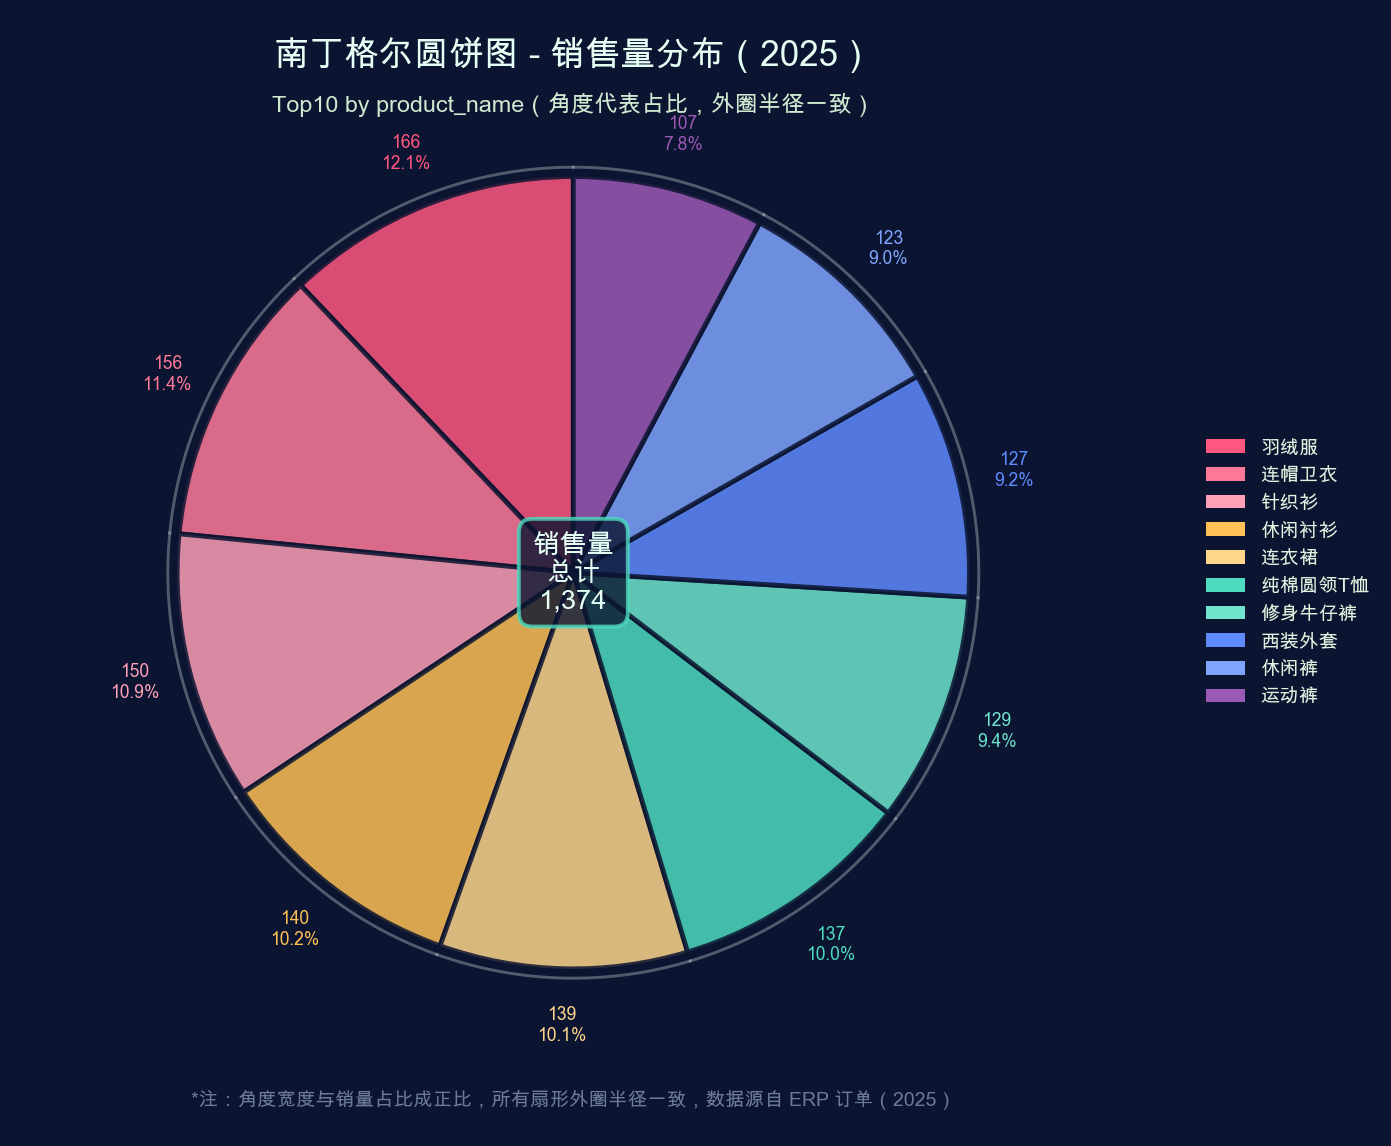

In [ ]:
date_col = PAYMENT_DATE_COL
value_col = QUANTITY_COL or AMOUNT_COL
category_col = next((c for c in ['product_name', 'province', 'store_name', 'category'] if c in df.columns), None)
df_rose = df.dropna(subset=[date_col]).copy()
df_2025 = df_rose[df_rose[date_col].dt.year == 2025].copy()
agg = df_2025.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
metric_name = '销售量' if value_col == QUANTITY_COL else '销售额'
agg = agg.sort_values('metric', ascending=False).head(12)
labels = agg[category_col].astype(str).tolist()
values = agg['metric'].astype(float).tolist()
if not values:
    raise ValueError('没有有效数据')

values_arr = np.array(values, dtype=float)
percentages = values_arr / values_arr.sum() * 100

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 10), dpi=140)
bg_color = '#0b1430'
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

base_colors = ['#ff577f', '#ff7a9a', '#ffa0b8', '#ffc155', '#ffd68b', '#4edbbf', '#6ee5cc', '#5f8bff', '#7fa5ff', '#9b59b6', '#b07cc6', '#e74c3c']
colors = [base_colors[i % len(base_colors)] for i in range(len(values))]

radius = 0.85
start_angle = 90
for val, pct, color, lab in zip(values, percentages, colors, labels):
    angle = pct * 3.6
    wedge = Wedge(center=(0, 0), r=radius, theta1=start_angle, theta2=start_angle + angle, facecolor=color, edgecolor=bg_color, linewidth=2.5, alpha=0.85, zorder=2)
    ax.add_patch(wedge)
    mid_angle = start_angle + angle / 2
    mid_rad = np.deg2rad(mid_angle)
    highlight_r = radius + 0.02
    arc_angles = np.linspace(start_angle, start_angle + angle, 30)
    ax.plot(highlight_r * np.cos(np.deg2rad(arc_angles)), highlight_r * np.sin(np.deg2rad(arc_angles)), color='white', alpha=0.3, linewidth=1.5, zorder=3)
    label_r = radius + 0.12
    label_x = label_r * np.cos(mid_rad)
    label_y = label_r * np.sin(mid_rad)
    ax.text(label_x, label_y, f'{val:,.0f}\n{pct:.1f}%', ha='center', va='center', fontsize=9, color=color, fontweight='bold', zorder=4)
    start_angle += angle

ax.text(0.5, 0.98, f'南丁格尔圆饼图 - {metric_name}分布（2025）', ha='center', va='top', fontsize=18, color='#e6fff5', fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.93, f'Top{len(labels)} by {category_col}（角度代表占比，外圈半径一致）', ha='center', va='top', fontsize=12, color='#cfead1', transform=ax.transAxes)

total_value = values_arr.sum()
ax.text(0, 0, f'{metric_name}\n总计\n{total_value:,.0f}', ha='center', va='center', fontsize=14, color='#e6fff5', fontweight='bold', zorder=10, bbox=dict(boxstyle='round,pad=0.5', facecolor=bg_color, edgecolor='#4edbbf', linewidth=2, alpha=0.8))

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='none') for i in range(len(labels))]
legend_labels = [lab if len(lab) <= 15 else lab[:13]+'..' for lab in labels]
ax.legend(legend_elements, legend_labels, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, fontsize=10, labelcolor='#dff3e0')
ax.text(0.5, 0.02, '*注：角度宽度与销量占比成正比，所有扇形外圈半径一致，数据源自 ERP 订单（2025）', ha='center', va='bottom', fontsize=10, color='#6b7a99', transform=ax.transAxes)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.show()

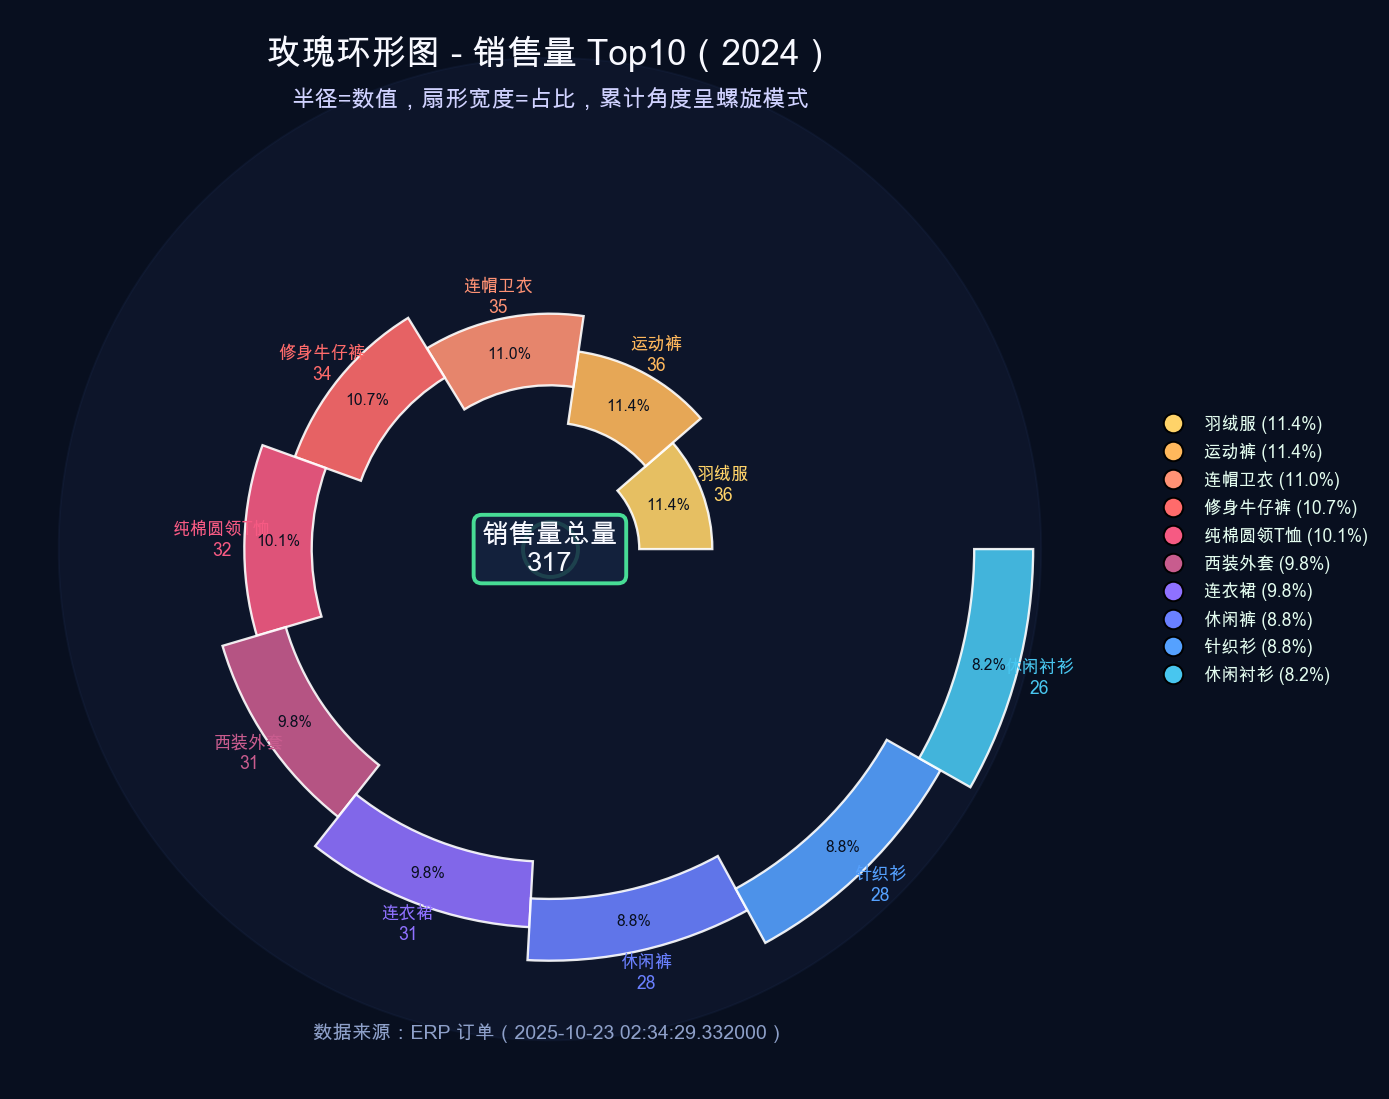

In [ ]:
date_col = PAYMENT_DATE_COL
value_col = QUANTITY_COL or AMOUNT_COL
category_col = next((c for c in ['category', 'product_name', 'province', 'store_name'] if c in df.columns), None)
df_rose = df.dropna(subset=[date_col]).copy()
df_2024 = df_rose[df_rose[date_col].dt.year == 2024].copy()
agg = df_2024.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
metric_name = '销售量' if value_col == QUANTITY_COL else '销售额'
agg = agg.sort_values('metric', ascending=False).head(12)
labels = agg[category_col].astype(str).tolist()
values = agg['metric'].astype(float).tolist()
if not values:
    raise ValueError('没有有效数据')

values_arr = np.array(values, dtype=float)
percentages = values_arr / values_arr.sum() * 100
cumulative_pct = np.cumsum(percentages)

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 10), dpi=140)
bg_color = '#080f1f'
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

palette = ['#ffd369', '#ffb85c', '#ff9274', '#ff6b6b', '#f65a83', '#c85c8e', '#8f71ff', '#6a80ff', '#55a1ff', '#48c6ef', '#56efca', '#4ade80']
colors = [palette[i % len(palette)] for i in range(len(values))]

radius_series = np.linspace(0.2, 0.95, len(values))
previous_angle = 0
for idx, (val, pct, cum_pct, color) in enumerate(zip(values, percentages, cumulative_pct, colors)):
    theta1 = previous_angle
    theta2 = cum_pct * 3.6
    radius = radius_series[idx]
    width = pct * 0.01 + 0.05
    wedge = Wedge(center=(0, 0), r=radius + width, theta1=theta1, theta2=theta2, facecolor=color, edgecolor='white', linewidth=1.2, alpha=0.9, width=width)
    ax.add_patch(wedge)
    mid_angle = np.deg2rad((theta1 + theta2) / 2)
    r_label = radius + width + 0.05
    ax.text(r_label * np.cos(mid_angle), r_label * np.sin(mid_angle), f'{labels[idx]}\n{val:,.0f}', color=color, fontsize=9, ha='center', va='center', fontweight='bold')
    if pct >= 5:
        ax.text((radius + width/2) * np.cos(mid_angle), (radius + width/2) * np.sin(mid_angle), f'{pct:.1f}%', color=bg_color, fontsize=8, ha='center', va='center', fontweight='bold')
    previous_angle = theta2

ax.text(0.5, 0.98, f'玫瑰环形图 - {metric_name} Top{len(labels)}（2024）', ha='center', va='top', fontsize=18, color='#f8f9ff', fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.93, '半径=数值，扇形宽度=占比，累计角度呈螺旋模式', ha='center', va='top', fontsize=12, color='#d0d2ff', transform=ax.transAxes)

total_value = values_arr.sum()
ax.text(0, 0, f'{metric_name}总量\n{total_value:,.0f}', ha='center', va='center', fontsize=14, color='#f8f9ff', fontweight='bold', bbox=dict(boxstyle='round', facecolor='#152440', edgecolor='#52ffa8', linewidth=2, alpha=0.85))

grad = np.linspace(0, 2*np.pi, 200)
ax.fill(1.1 * np.cos(grad), 1.1 * np.sin(grad), color='#1c2a4d', alpha=0.25, zorder=0)
ax.scatter(0, 0, s=800, facecolor='#0e1624', edgecolor='#52ffa8', linewidth=2, alpha=0.9, zorder=1)

legend_elements = [plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=colors[i], markersize=10) for i in range(len(labels))]
legend_labels = [f'{labels[i]} ({percentages[i]:.1f}%)' if len(labels[i]) <= 15 else f'{labels[i][:13]}.. ({percentages[i]:.1f}%)' for i in range(len(labels))]
ax.legend(legend_elements, legend_labels, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False, labelcolor='#e3fcef')
ax.text(0.5, 0.04, f'数据来源：ERP 订单（{NOTE_DATE}）', ha='center', va='bottom', fontsize=10, color='#8ea0c9', transform=ax.transAxes)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.show()

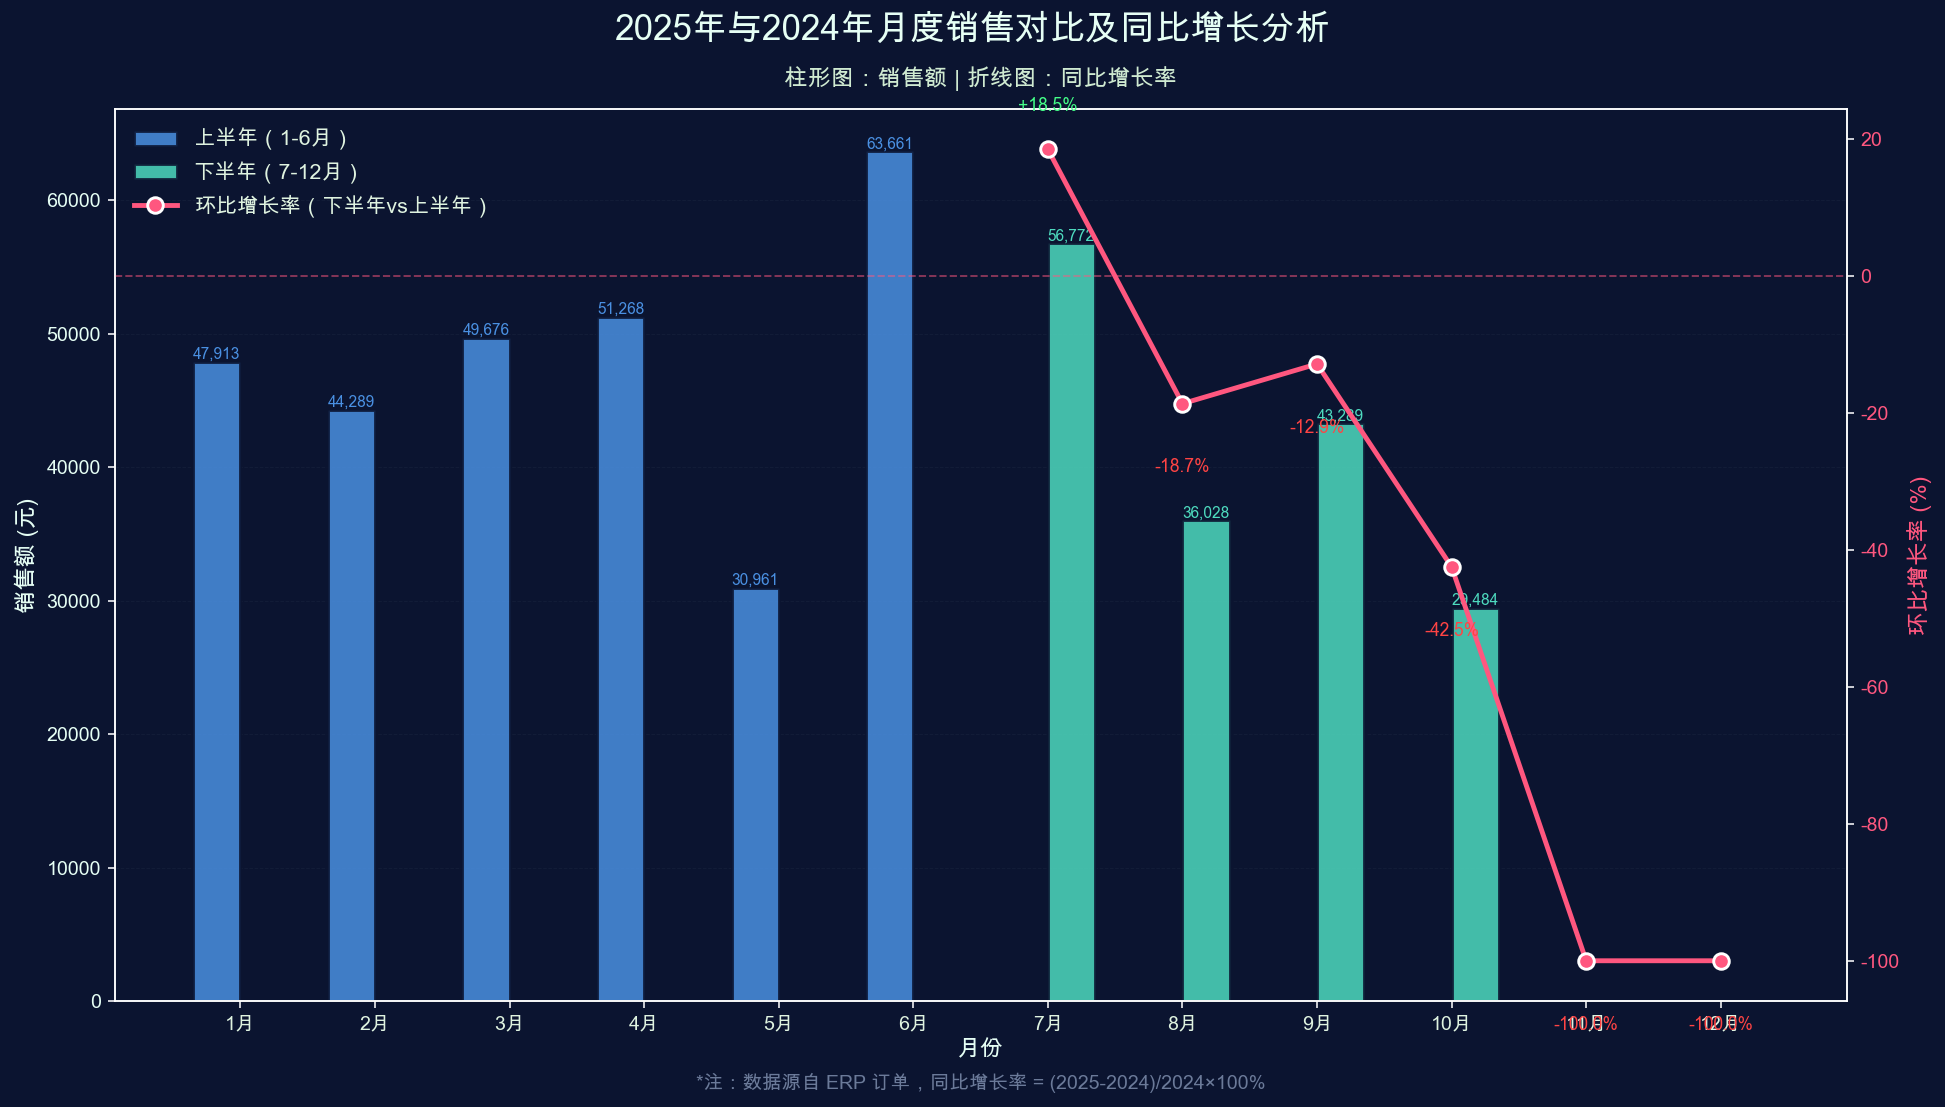

In [ ]:
# 柱形折线组合图（2025年下半年对比上半年）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 数据准备
df_combo = df.copy()

# 自动选择日期与金额列
date_col = next((c for c in ['payment_date','order_date','create_time'] if c in df_combo.columns), None)
amount_col = next((c for c in ['paid_amount','product_amount','amount','total_amount'] if c in df_combo.columns), None)
qty_col = 'quantity' if 'quantity' in df_combo.columns else None

# 解析日期并筛选 2025 年数据
df_combo[date_col] = pd.to_datetime(df_combo[date_col])
df_combo['year'] = df_combo[date_col].dt.year
df_combo['month'] = df_combo[date_col].dt.month

df_2025 = df_combo[df_combo['year'] == 2025].copy()

if df_2025.shape[0] == 0:
    raise ValueError('需要包含 2025 年数据')

# 选择指标
if amount_col:
    metric_col = amount_col
    metric_name = '销售额'
    unit = '元'
else:
    metric_col = qty_col
    metric_name = '销售量'
    unit = '件'

# 区分上半年（1-6月）和下半年（7-12月）
df_h1 = df_2025[df_2025['month'] <= 6].copy()
df_h2 = df_2025[df_2025['month'] > 6].copy()

# 按月聚合
monthly_h1 = df_h1.groupby('month')[metric_col].sum().reset_index()
monthly_h1.columns = ['month', 'value_h1']

monthly_h2 = df_h2.groupby('month')[metric_col].sum().reset_index()
monthly_h2.columns = ['month', 'value_h2']

# 合并数据（补齐月份）
all_months = pd.DataFrame({'month': range(1, 13)})
merged = all_months.merge(monthly_h1, on='month', how='left')
merged = merged.merge(monthly_h2, on='month', how='left')
merged = merged.fillna(0)

# 计算环比增长率（下半年对应月与上半年对应月对比）
# 例如：7月对比1月，8月对比2月，以此类推
merged['mom_rate'] = 0.0
for i in range(6, 12):  # 7-12月
    h1_month = i - 5  # 对应的上半年月份（1-6月）
    h2_month = i + 1  # 下半年月份（7-12月）
    h1_val = merged.loc[merged['month'] == h1_month, 'value_h1'].values[0] if len(merged.loc[merged['month'] == h1_month, 'value_h1'].values) > 0 else 0
    h2_val = merged.loc[merged['month'] == h2_month, 'value_h2'].values[0] if len(merged.loc[merged['month'] == h2_month, 'value_h2'].values) > 0 else 0
    if h1_val > 0:
        rate = ((h2_val - h1_val) / h1_val) * 100
        merged.loc[merged['month'] == h2_month, 'mom_rate'] = rate

months = merged['month'].values
values_h1 = merged['value_h1'].values
values_h2 = merged['value_h2'].values
mom_rates = merged['mom_rate'].values

# 2. 视觉设置
plt.close('all')
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(14, 8), dpi=140)
bg_color = '#0b1430'
fig.patch.set_facecolor(bg_color)
ax1.set_facecolor(bg_color)

# 3. 绘制柱形图（左轴）
bar_width = 0.35
x_pos = np.arange(len(months))

bars_h1 = ax1.bar(x_pos - bar_width/2, values_h1, bar_width, 
                  label='上半年（1-6月）', color='#4a90e2', alpha=0.85, 
                  edgecolor='#0b1430', linewidth=1.5, zorder=2)

bars_h2 = ax1.bar(x_pos + bar_width/2, values_h2, bar_width, 
                  label='下半年（7-12月）', color='#4edbbf', alpha=0.85, 
                  edgecolor='#0b1430', linewidth=1.5, zorder=2)

# 柱形顶部数值标签
for i, (vh1, vh2) in enumerate(zip(values_h1, values_h2)):
    if vh1 > 0:
        ax1.text(i - bar_width/2, vh1, f'{vh1:,.0f}', 
                ha='center', va='bottom', fontsize=8, 
                color='#4a90e2', fontweight='bold', zorder=3)
    if vh2 > 0:
        ax1.text(i + bar_width/2, vh2, f'{vh2:,.0f}', 
                ha='center', va='bottom', fontsize=8, 
                color='#4edbbf', fontweight='bold', zorder=3)

# 配置左轴
ax1.set_xlabel('月份', fontsize=12, color='#e6fff5', fontweight='bold')
ax1.set_ylabel(f'{metric_name} ({unit})', fontsize=12, color='#e6fff5', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{m}月' for m in months], fontsize=10, color='#dff3e0')
ax1.tick_params(axis='y', labelcolor='#e6fff5', labelsize=10)
ax1.grid(axis='y', color='#1a2540', linestyle='--', linewidth=0.5, alpha=0.5)

# 4. 绘制折线图（右轴 - 环比增长率）
ax2 = ax1.twinx()

# 只显示下半年月份（7-12月）的环比增长率
line_months = x_pos[6:]  # 7-12月对应的 x 位置
line_rates = mom_rates[6:]  # 7-12月的环比增长率

line = ax2.plot(line_months, line_rates, color='#ff577f', marker='o', 
               markersize=8, linewidth=2.5, label='环比增长率（下半年vs上半年）', 
               zorder=4, markeredgecolor='white', markeredgewidth=1.5)

# 折线数据标签
for i, rate in zip(line_months, line_rates):
    color = '#44ff88' if rate >= 0 else '#ff4444'
    sign = '+' if rate >= 0 else ''
    ax2.text(i, rate + (5 if rate >= 0 else -8), f'{sign}{rate:.1f}%', 
            ha='center', va='bottom' if rate >= 0 else 'top', 
            fontsize=9, color=color, fontweight='bold', zorder=5)

# 配置右轴
ax2.set_ylabel('环比增长率 (%)', fontsize=12, color='#ff577f', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#ff577f', labelsize=10)
ax2.axhline(y=0, color='#ff577f', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# 5. 标题
fig.suptitle('2025年与2024年月度销售对比及同比增长分析', 
            fontsize=18, color='#e6fff5', fontweight='bold', y=0.98)
ax1.text(0.5, 1.02, f'柱形图：{metric_name} | 折线图：同比增长率', 
        ha='center', va='bottom', fontsize=12, 
        color='#cfead1', transform=ax1.transAxes)

# 6. 图例
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', frameon=False, 
          fontsize=11, labelcolor='#dff3e0')

# 7. 注释
ax1.text(0.5, -0.08, '*注：数据源自 ERP 订单，同比增长率 = (2025-2024)/2024×100%', 
        ha='center', va='top', fontsize=10, 
        color='#6b7a99', transform=ax1.transAxes)

plt.tight_layout()
plt.show()


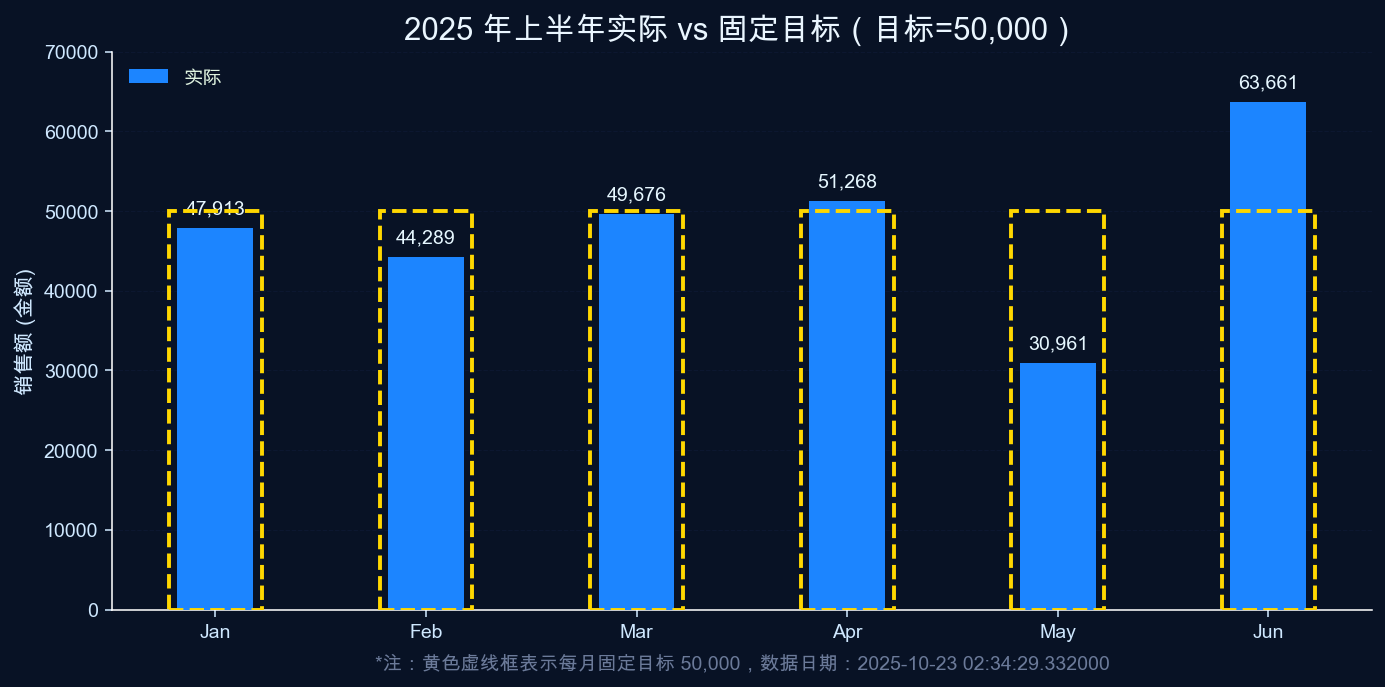

In [ ]:
date_col = PAYMENT_DATE_COL
value_col = AMOUNT_COL or QUANTITY_COL
df_h1 = df.dropna(subset=[date_col]).copy()
df_h1['year'] = df_h1[date_col].dt.year
df_h1['month'] = df_h1[date_col].dt.month
df_2025 = df_h1[df_h1['year'] == 2025]
months = list(range(1, 7))
monthly_actual = (
    df_2025[df_2025['month'].isin(months)]
    .groupby('month')[value_col]
    .sum()
    .reindex(months, fill_value=0)
)
metric_name = '销售额' if value_col == AMOUNT_COL else '销量'
unit = '金额' if metric_name == '销售额' else '数量'

fixed_target = 50000.0
x = np.arange(len(months))
width = 0.36

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 5), dpi=140)
fig.patch.set_facecolor('#081225')
ax.set_facecolor('#081225')

ax.bar(x, monthly_actual.values, width, color='#1c85ff', label='实际', zorder=3)
frame_width = width + 0.08
for i, month in enumerate(months):
    left = x[i] - frame_width / 2
    rect = Rectangle((left, 0), frame_width, fixed_target, fill=False, edgecolor='#ffd700', linewidth=2, linestyle='--', zorder=4)
    ax.add_patch(rect)
max_ref = max(monthly_actual.max(), fixed_target, 1)
for i, val in enumerate(monthly_actual.values):
    ax.text(x[i], val + max_ref * 0.02, f'{val:,.0f}', ha='center', va='bottom', color='#e6f7ff', fontsize=10, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], color='#cfe8ff', fontsize=10)
ax.set_ylabel(f'{metric_name} ({unit})', color='#cfe8ff', fontsize=11)
ax.set_ylim(0, max_ref * 1.1)
ax.set_title('2025 年上半年实际 vs 固定目标（目标=50,000）', color='#eaf6ff', fontsize=16, fontweight='bold')
ax.legend(frameon=False, fontsize=10, labelcolor='#dff3e0')
ax.text(0.5, -0.08, f'*注：黄色虚线框表示每月固定目标 50,000，数据日期：{NOTE_DATE}', ha='center', va='top', fontsize=10, color='#6b7a99', transform=ax.transAxes)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.tick_params(colors='#cfe8ff')
ax.grid(axis='y', color='#142041', linestyle='--', linewidth=0.6, alpha=0.4, zorder=0)

plt.tight_layout()
plt.show()

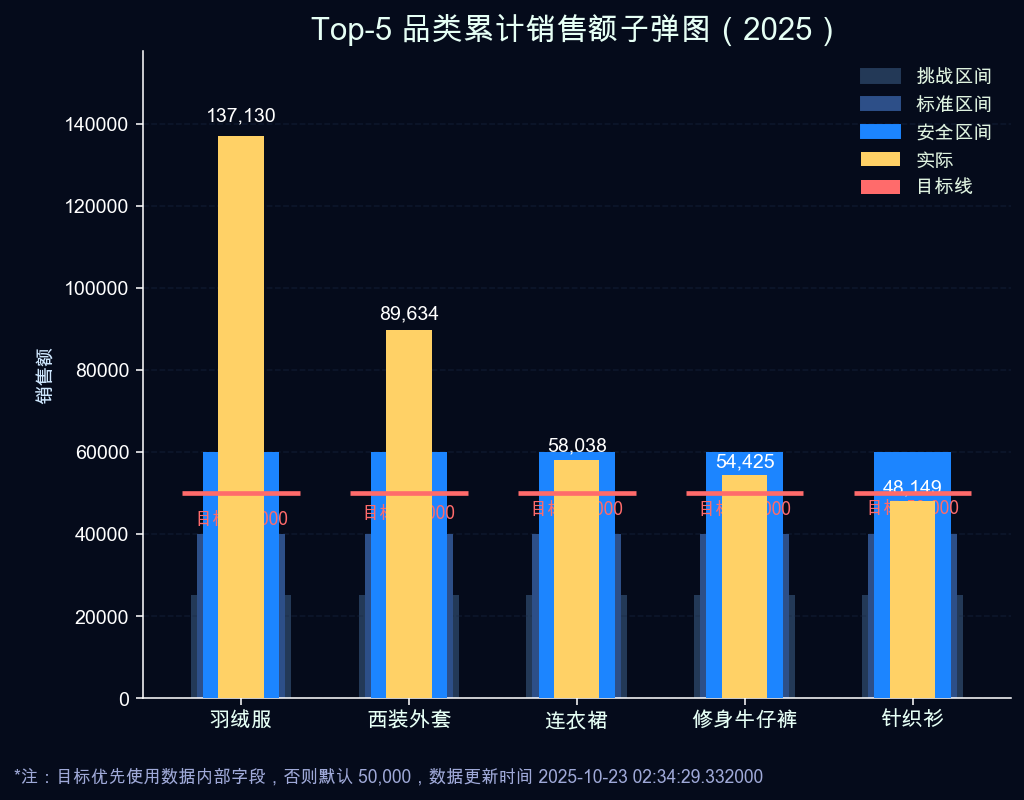

In [ ]:
value_col = AMOUNT_COL or QUANTITY_COL
category_candidates = ['category', 'product_category', 'product_name', 'province', 'store_name']
category_col = next((c for c in category_candidates if c in df.columns), None)
date_col = PAYMENT_DATE_COL or ORDER_DATE_COL
df_bullet = df.dropna(subset=[value_col]).copy()
if date_col in df_bullet.columns:
    df_bullet = df_bullet.dropna(subset=[date_col]).copy()
    df_bullet['year'] = df_bullet[date_col].dt.year
    df_2025 = df_bullet[df_bullet['year'] == 2025]
agg = df_bullet.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
agg = agg.sort_values('metric', ascending=False).head(5).reset_index(drop=True)
target_candidates = ['category_target', 'target_amount', 'target']
target_map = {}
for col in target_candidates:
    if col in df_bullet.columns:
        target_map = df_bullet.groupby(category_col)[col].sum().to_dict()
        break
default_target = 50000.0
labels = agg[category_col].astype(str).tolist()
actuals = agg['metric'].astype(float).tolist()
targets = [float(target_map.get(label, default_target)) if target_map else default_target for label in labels]
ranges = [(0.5*t, 0.8*t, 1.2*t) for t in targets]
metric_name = '销售额' if value_col == AMOUNT_COL else '销量'

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(max(8, len(labels) * 1.6), 6), dpi=140)
fig.patch.set_facecolor('#050b1b')
ax.set_facecolor('#050b1b')

x = np.arange(len(labels))
base_width = 0.6
range_colors = ['#233957', '#2d4f88', '#1c85ff']
for xi, (r3, r2, r1) in enumerate(ranges):
    ax.bar(xi, r3, width=base_width, color=range_colors[0], zorder=1)
    ax.bar(xi, r2, width=base_width * 0.88, color=range_colors[1], zorder=2)
    ax.bar(xi, r1, width=base_width * 0.76, color=range_colors[2], zorder=3)
ax.bar(x, actuals, width=base_width * 0.45, color='#ffd166', zorder=4, label='实际')
for xi, (tgt, val) in enumerate(zip(targets, actuals)):
    ax.hlines(tgt, xi - base_width/2 - 0.05, xi + base_width/2 + 0.05, colors='#ff6b6b', linewidth=2.4, zorder=5)
    ax.text(xi, val + 0.02 * max(val, tgt, 1), f'{val:,.0f}', ha='center', va='bottom', color='#ffffff', fontsize=10)
    ax.text(xi, tgt - 0.03 * max(val, tgt, 1), f'目标 {tgt:,.0f}', ha='center', va='top', color='#ff6b6b', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, color='#e6fff5')
global_max = max([max(actuals + targets), max(r[2] for r in ranges), 1.0])
ax.set_ylim(0, global_max * 1.15)
ax.set_ylabel(metric_name, color='#cfe8ff')
ax.set_title(f'Top-5 品类累计{metric_name}子弹图（2025）', color='#e6fff5', fontsize=16, fontweight='bold')
legend_handles = [Patch(color=range_colors[0], label='挑战区间'), Patch(color=range_colors[1], label='标准区间'), Patch(color=range_colors[2], label='安全区间'), Patch(facecolor='#ffd166', edgecolor='none', label='实际'), Patch(facecolor='#ff6b6b', edgecolor='none', label='目标线')]
ax.legend(handles=legend_handles, loc='upper right', frameon=False, fontsize=10, labelcolor='#dff3e0')
ax.text(0.01, 0.01, f'*注：目标优先使用数据内部字段，否则默认 {default_target:,.0f}，数据更新时间 {NOTE_DATE}', fontsize=9, color='#9fa9d8', transform=fig.transFigure)
ax.grid(axis='y', linestyle='--', color='#1b2a46', alpha=0.4)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()

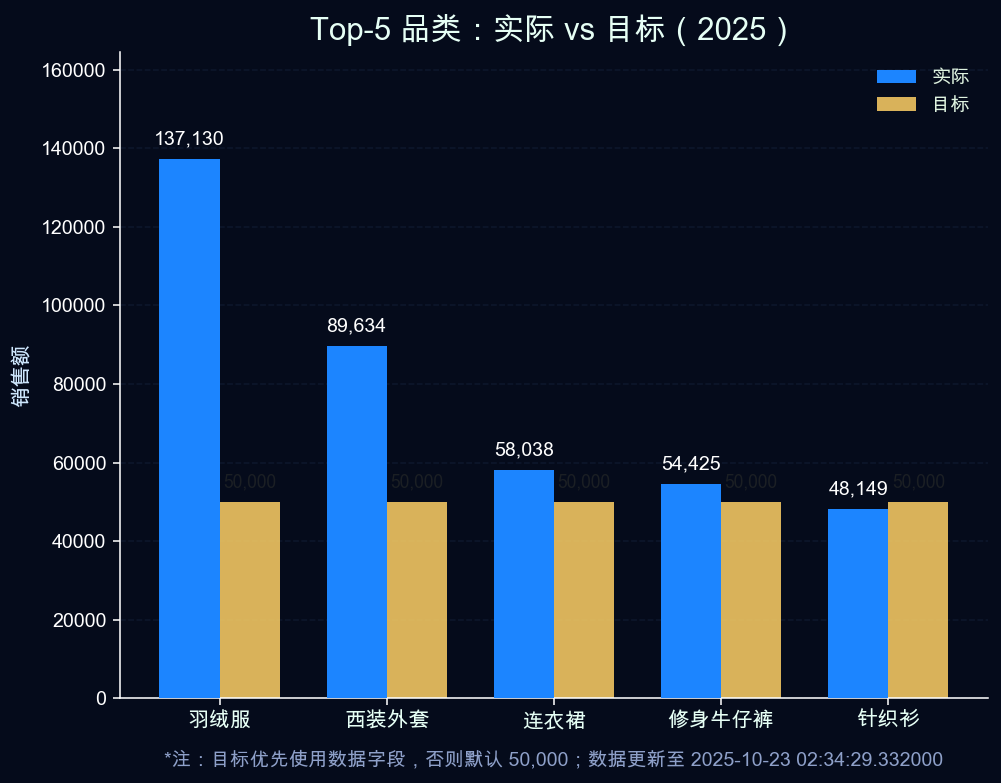

In [ ]:
value_col = AMOUNT_COL or QUANTITY_COL
category_col = next((c for c in ['category', 'product_category', 'product_name', 'province', 'store_name'] if c in df.columns), None)
date_col = PAYMENT_DATE_COL or ORDER_DATE_COL
df_bar = df.dropna(subset=[value_col]).copy()
if date_col in df_bar.columns:
    df_bar = df_bar.dropna(subset=[date_col]).copy()
    df_bar['year'] = df_bar[date_col].dt.year
    df_2025 = df_bar[df_bar['year'] == 2025]
agg = df_bar.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
agg = agg.sort_values('metric', ascending=False).head(5).reset_index(drop=True)
target_candidates = ['category_target', 'target_amount', 'target']
target_map = {}
for col in target_candidates:
    if col in df_bar.columns:
        target_map = df_bar.groupby(category_col)[col].sum().to_dict()
        break
default_target = 50000.0
labels = agg[category_col].astype(str).tolist()
actuals = agg['metric'].astype(float).tolist()
targets = [float(target_map.get(label, default_target)) if target_map else default_target for label in labels]
metric_name = '销售额' if value_col == AMOUNT_COL else '销量'

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(max(8, len(labels) * 1.6), 6), dpi=140)
fig.patch.set_facecolor('#050b1b')
ax.set_facecolor('#050b1b')

x = np.arange(len(labels))
width = 0.36
bars_actual = ax.bar(x - width/2, actuals, width, label='实际', color='#1c85ff', zorder=3)
bars_target = ax.bar(x + width/2, targets, width, label='目标', color='#ffd166', alpha=0.85, zorder=2)
global_max = max([max(actuals + targets), 1.0])
for rect, val in zip(bars_actual, actuals):
    ax.text(rect.get_x() + rect.get_width()/2, val + global_max*0.02, f'{val:,.0f}', ha='center', va='bottom', color='white', fontsize=10)
for rect, tgt in zip(bars_target, targets):
    ax.text(rect.get_x() + rect.get_width()/2, tgt + global_max*0.02, f'{tgt:,.0f}', ha='center', va='bottom', color='#1b1f24', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, color='#e6fff5')
ax.set_ylim(0, global_max * 1.2)
ax.set_ylabel(metric_name, color='#cfe8ff', fontsize=11)
ax.legend(frameon=False, fontsize=10, labelcolor='#dff3e0')
ax.set_title(f'Top-5 品类：实际 vs 目标（2025）', fontsize=16, color='#e6fff5', fontweight='bold')
ax.text(0.5, -0.08, f'*注：目标优先使用数据字段，否则默认 {default_target:,.0f}；数据更新至 {NOTE_DATE}', ha='center', va='top', fontsize=10, color='#8ea0c9', transform=ax.transAxes)
ax.grid(axis='y', linestyle='--', color='#1b2a46', alpha=0.4)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()

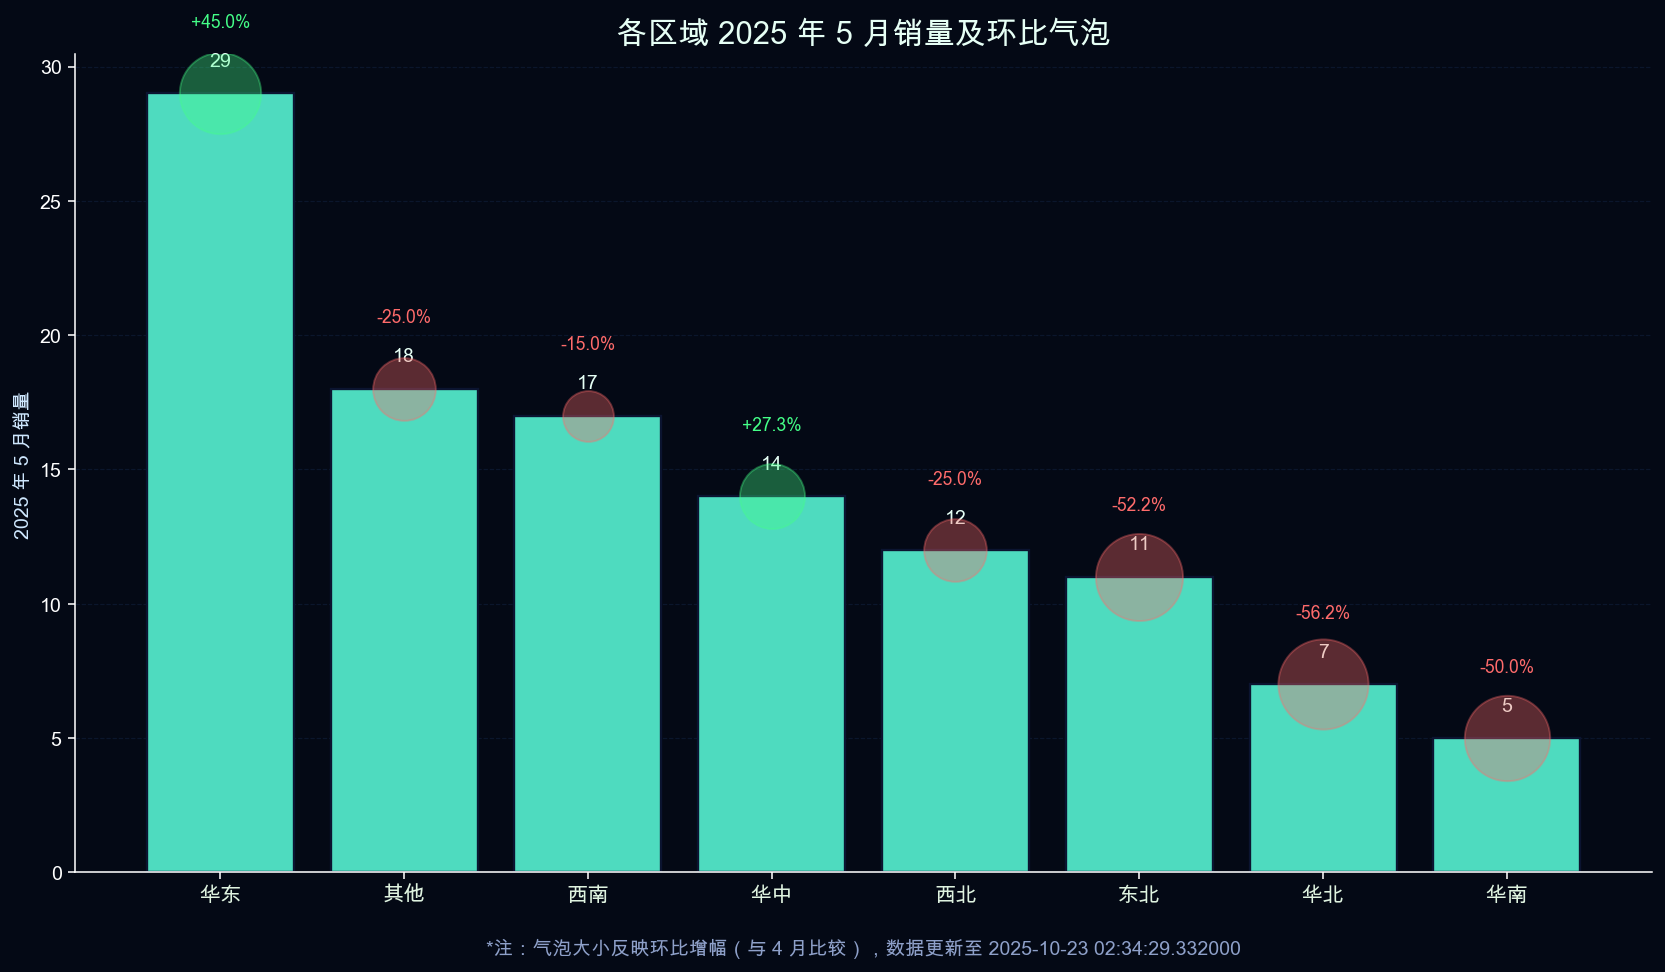

In [ ]:
date_col = PAYMENT_DATE_COL
value_col = QUANTITY_COL or AMOUNT_COL
df_region = df.dropna(subset=[date_col]).copy()
df_region['year'] = df_region[date_col].dt.year
df_region['month'] = df_region[date_col].dt.month
df_region['region'] = df_region['region'].fillna('其他')
may = df_region[(df_region['year'] == 2025) & (df_region['month'] == 5)]
april = df_region[(df_region['year'] == 2025) & (df_region['month'] == 4)]
may_agg = may.groupby('region', as_index=False)[value_col].sum().rename(columns={value_col: 'current'})
apr_agg = april.groupby('region', as_index=False)[value_col].sum().rename(columns={value_col: 'previous'})
region_stats = pd.merge(may_agg, apr_agg, on='region', how='left').fillna({'previous': 0})
region_stats['mom'] = region_stats.apply(lambda row: (row['current'] - row['previous']) / row['previous'] * 100 if row['previous'] else (np.inf if row['current'] > 0 else 0), axis=1)
metric_name = '销量' if value_col == QUANTITY_COL else '销售额'

region_stats = region_stats.sort_values('current', ascending=False)
regions = region_stats['region'].tolist()
current_vals = region_stats['current'].tolist()
mom_vals = region_stats['mom'].replace(np.inf, np.nan).tolist()

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7), dpi=140)
fig.patch.set_facecolor('#040915')
ax.set_facecolor('#040915')

x = np.arange(len(regions))
bars = ax.bar(x, current_vals, color='#4edbbf', edgecolor='#0b1430', linewidth=1.2, zorder=2)
for xi, val in enumerate(current_vals):
    ax.text(xi, val + max(current_vals) * 0.03, f'{val:,.0f}', ha='center', va='bottom', color='#e6fff5', fontsize=10, fontweight='bold')

bubble_sizes = [abs(m) if not np.isnan(m) else 0 for m in mom_vals]
max_bubble = max(bubble_sizes) if bubble_sizes else 0
norm_sizes = [150 + (2000 * (s / max_bubble if max_bubble else 0)) for s in bubble_sizes]
for xi, (bar, mom, size) in enumerate(zip(bars, mom_vals, norm_sizes)):
    color = '#44ff88' if mom is not None and mom >= 0 else '#ff6b6b'
    text = '新增长' if np.isnan(mom) else f'{mom:+.1f}%'
    ax.scatter(bar.get_x() + bar.get_width()/2, bar.get_height(), s=size, color=color, alpha=0.35, zorder=3)
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(current_vals)*0.08, text, ha='center', va='bottom', color=color, fontsize=9, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=0, fontsize=11, color='#dff3e0')
ax.set_ylabel(f'2025 年 5 月{metric_name}', color='#cfe8ff')
ax.set_title(f'各区域 2025 年 5 月{metric_name}及环比气泡', fontsize=16, color='#e6fff5', fontweight='bold')
ax.text(0.5, -0.08, f'*注：气泡大小反映环比增幅（与 4 月比较），数据更新至 {NOTE_DATE}', fontsize=10, color='#8ea0c9', ha='center', va='top', transform=ax.transAxes)
ax.grid(axis='y', color='#122444', linestyle='--', linewidth=0.6, alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

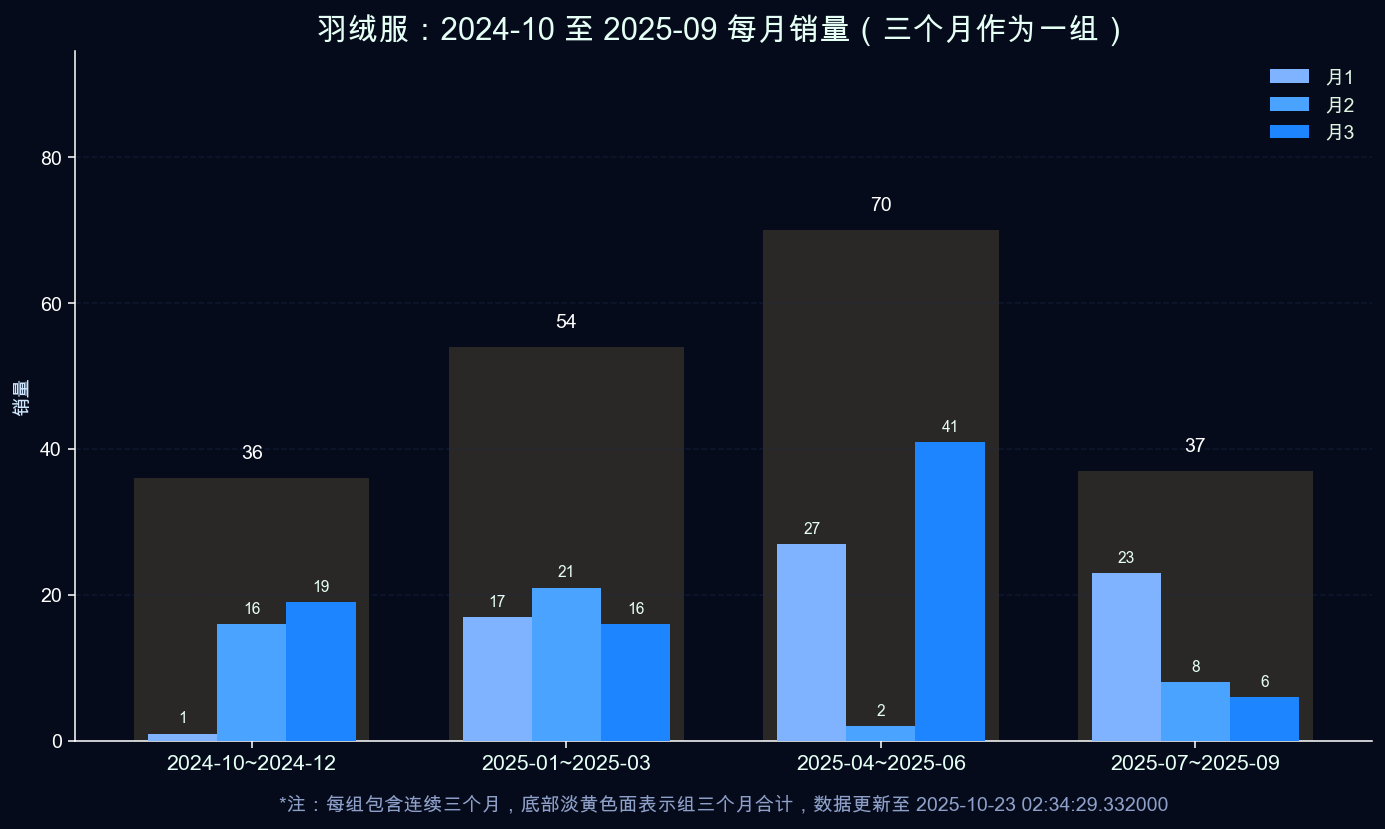

In [ ]:
date_col = PRIMARY_DATE_COL
value_col = QUANTITY_COL or AMOUNT_COL
product_cols = [c for c in ['product_name', 'product', 'product_title', 'title', 'category', 'product_category'] if c in df.columns]
if not product_cols:
    raise ValueError('未找到商品/品类字段')

mask = pd.Series(False, index=df.index)
for col in product_cols:
    mask = mask | df[col].astype(str).str.contains('羽绒服', na=False)
if not mask.any():
    raise ValueError('没有包含“羽绒服”的记录')

df_down = df.loc[mask].dropna(subset=[date_col]).copy()
start = pd.Timestamp('2024-10-01')
end = pd.Timestamp('2025-09-30')
df_down = df_down[(df_down[date_col] >= start) & (df_down[date_col] <= end)]
months = pd.date_range(start=start, end=end, freq='MS')
df_down['year_month'] = df_down[date_col].dt.to_period('M').dt.to_timestamp()
monthly = df_down.groupby('year_month', as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
monthly = pd.merge(pd.DataFrame({'year_month': months}), monthly, on='year_month', how='left').fillna({'metric': 0.0})
monthly['month_idx'] = np.arange(len(monthly))
monthly['group_idx'] = monthly['month_idx'] // 3
monthly['group_label'] = monthly['group_idx'].apply(lambda g: f"{months[g*3].strftime('%Y-%m')}~{months[min(len(months)-1, g*3+2)].strftime('%Y-%m')}")
group_totals = monthly.groupby('group_idx', as_index=False)['metric'].sum().rename(columns={'metric': 'group_total'})
groups = sorted(monthly['group_idx'].unique())
month_values = {g: monthly[monthly['group_idx'] == g]['metric'].tolist() for g in groups}
for g, vals in month_values.items():
    if len(vals) < 3:
        month_values[g] = vals + [0.0] * (3 - len(vals))
labels = [monthly.loc[monthly['group_idx'] == g, 'group_label'].iloc[0] for g in groups]
group_vals = [group_totals.loc[group_totals['group_idx'] == g, 'group_total'].iloc[0] for g in groups]
metric_name = '销量' if value_col == QUANTITY_COL else '销售额'

DOWN_JACKET_GROUP_DATA = {
    'monthly': monthly.copy(),
    'labels': labels,
    'group_totals': group_vals,
    'month_values': month_values,
    'metric_name': metric_name
}

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(max(10, len(groups) * 2.5), 6), dpi=140)
fig.patch.set_facecolor('#050b1b')
ax.set_facecolor('#050b1b')

width = 0.22
x = np.arange(len(groups))
offsets = np.array([-1, 0, 1]) * width
colors = ['#7fb3ff', '#4aa3ff', '#1c85ff']
containers = []
for idx in range(3):
    vals = [month_values[g][idx] for g in groups]
    container = ax.bar(x + offsets[idx], vals, width, label=f'月{idx+1}', color=colors[idx], zorder=4)
    containers.append(container)
pad = width * 0.2
max_group = max(group_vals) if group_vals else 1
for i, total in enumerate(group_vals):
    left = x[i] + offsets.min() - width/2 - pad
    rect_w = (offsets.max() - offsets.min()) + width + 2 * pad
    ax.add_patch(Rectangle((left, 0), rect_w, total, facecolor='#ffd166', alpha=0.15, edgecolor=None, zorder=1))
    ax.text(x[i], total + max_group * 0.03, f'{total:,.0f}', ha='center', va='bottom', color='#ffffff', fontsize=10)
max_month = max(monthly['metric'].max(), max_group, 1.0)
for container in containers:
    for rect in container:
        h = rect.get_height()
        if h > 0:
            ax.text(rect.get_x() + rect.get_width()/2, h + max_month * 0.015, f'{h:,.0f}', ha='center', va='bottom', color='#e6fff5', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, color='#e6fff5')
ax.set_ylabel(metric_name, color='#cfe8ff')
ax.set_ylim(0, max_month * 1.35)
ax.set_title('羽绒服：2024-10 至 2025-09 每月销量（三个月作为一组）', color='#e6fff5', fontsize=16, fontweight='bold')
ax.legend(frameon=False, fontsize=10, labelcolor='#dff3e0')
ax.text(0.5, -0.08, f'*注：每组包含连续三个月，底部淡黄色面表示组三个月合计，数据更新至 {NOTE_DATE}', ha='center', va='top', fontsize=10, color='#8ea0c9', transform=ax.transAxes)
ax.grid(axis='y', linestyle='--', color='#1b2a46', alpha=0.4)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

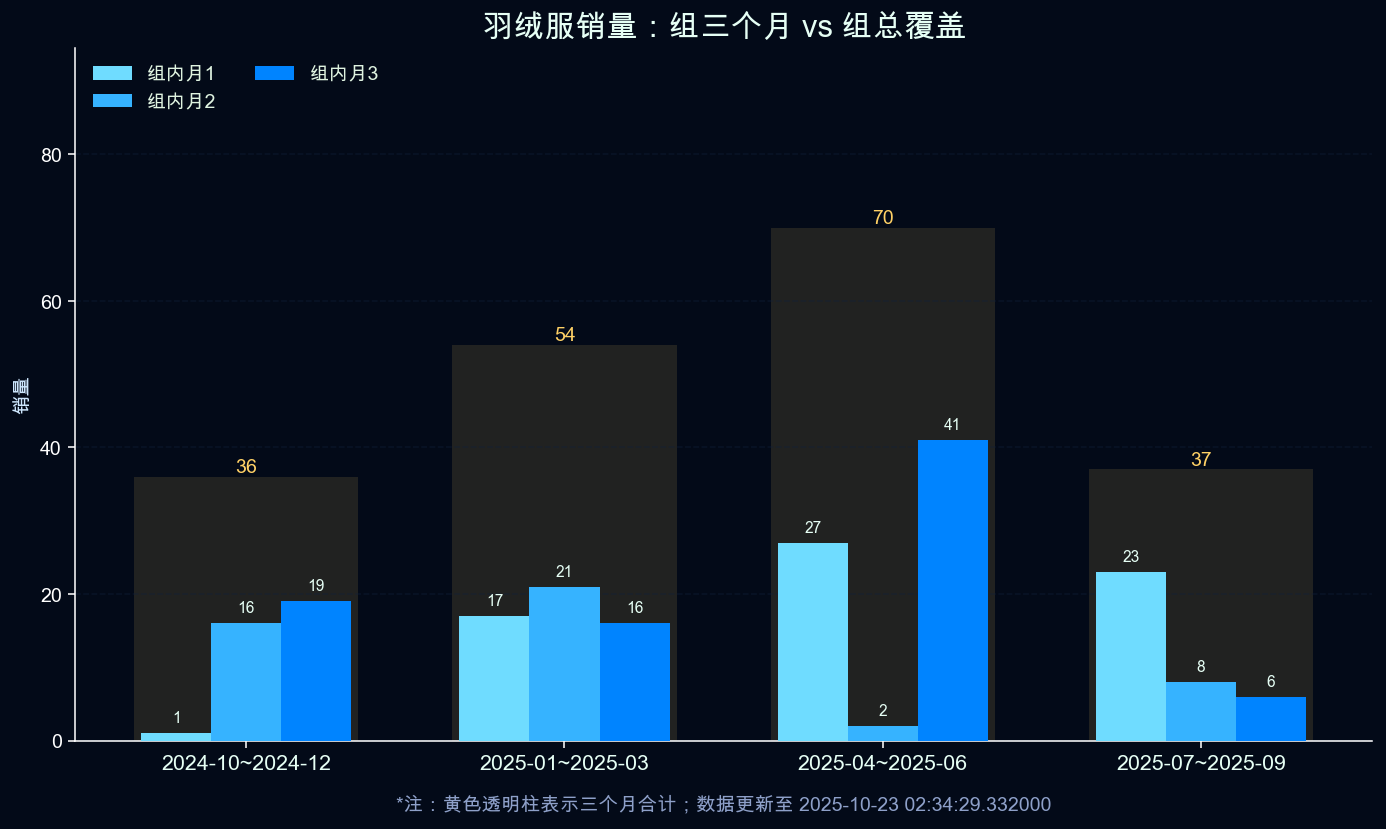

In [ ]:
group_data = globals().get('DOWN_JACKET_GROUP_DATA')
if not group_data:
    raise ValueError('请先运行上一单元以生成 DOWN_JACKET_GROUP_DATA')

labels = group_data['labels']
group_totals = group_data['group_totals']
month_values = group_data['month_values']
metric_name = group_data['metric_name']
groups = list(month_values.keys())

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(max(10, len(labels) * 2.3), 6), dpi=140)
fig.patch.set_facecolor('#030a18')
ax.set_facecolor('#030a18')

width = 0.22
x = np.arange(len(labels))
offsets = np.array([-1, 0, 1]) * width
colors = ['#6fdcff', '#36b3ff', '#0084ff']
containers = []
for idx in range(3):
    vals = [month_values[g][idx] for g in groups]
    container = ax.bar(x + offsets[idx], vals, width, color=colors[idx], label=f'组内月{idx+1}', zorder=4)
    containers.append(container)
for idx, total in enumerate(group_totals):
    ax.bar(x[idx], total, width * 3.2, color='#ffd166', alpha=0.12, zorder=1)
    ax.text(x[idx], total, f'{total:,.0f}', ha='center', va='bottom', color='#ffd166', fontsize=10)
max_value = max(max(group_totals), max(max(vals) for vals in month_values.values()), 1.0)
for container in containers:
    for rect in container:
        if rect.get_height() <= 0:
            continue
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + max_value * 0.015, f'{rect.get_height():,.0f}', ha='center', va='bottom', color='#e6fff5', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, color='#e6fff5')
ax.set_ylabel(metric_name, color='#cfe8ff')
ax.set_title('羽绒服销量：组三个月 vs 组总覆盖', fontsize=16, color='#e6fff5', fontweight='bold')
ax.legend(frameon=False, fontsize=10, labelcolor='#dff3e0', loc='upper left', ncol=2)
ax.text(0.5, -0.08, f'*注：黄色透明柱表示三个月合计；数据更新至 {NOTE_DATE}', ha='center', va='top', fontsize=10, color='#8ea0c9', transform=ax.transAxes)
ax.grid(axis='y', linestyle='--', color='#11203a', alpha=0.45)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.set_ylim(0, max_value * 1.35)
plt.tight_layout()
plt.show()

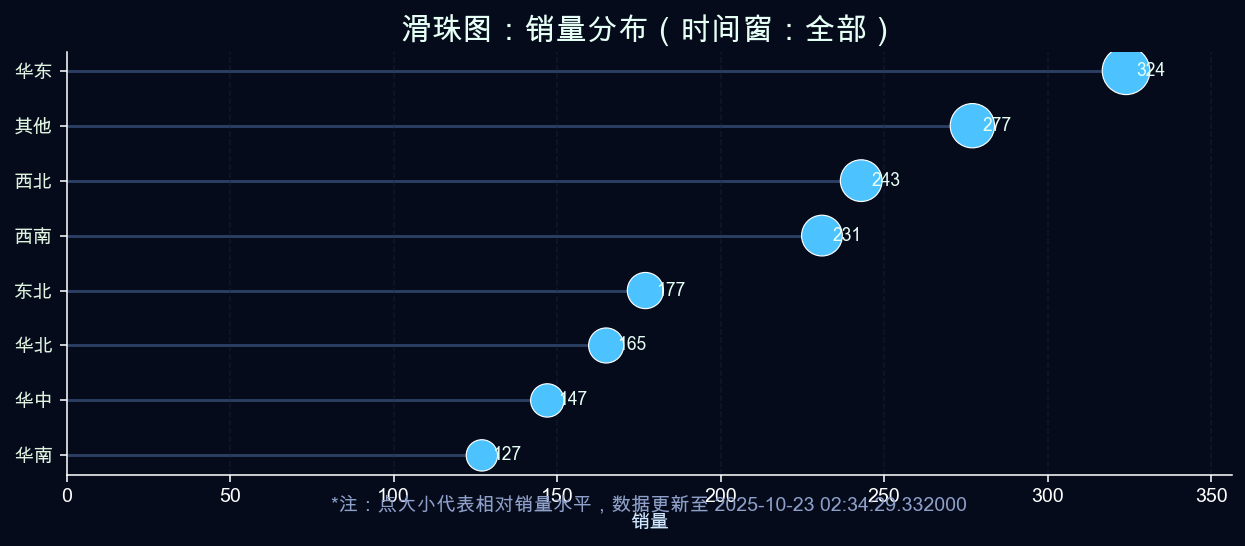

In [ ]:
value_col = QUANTITY_COL or AMOUNT_COL
category_col = next((c for c in ['region', 'category', 'product_category', 'product_name', 'province', 'store_name'] if c in df.columns), None)
date_col = PRIMARY_DATE_COL
df_lollipop = df.dropna(subset=[value_col]).copy()
subtitle = '时间窗：全部'
if date_col in df_lollipop.columns:
    df_lollipop = df_lollipop.dropna(subset=[date_col]).copy()
    df_lollipop['year'] = df_lollipop[date_col].dt.year
    df_lollipop['month'] = df_lollipop[date_col].dt.month
    df_may = df_lollipop[(df_lollipop['year'] == 2025) & (df_lollipop['month'] == 5)]
agg = df_lollipop.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'metric'})
agg = agg.sort_values('metric', ascending=True).reset_index(drop=True)
labels = agg[category_col].astype(str).tolist()
values = agg['metric'].astype(float).tolist()
y = np.arange(len(labels))
maxv = max(max(values), 1.0)
sizes = ((np.array(values) / maxv) * 560) + 40
metric_name = '销量' if value_col == QUANTITY_COL else '销售额'

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(9, max(4, len(labels) * 0.35)), dpi=140)
fig.patch.set_facecolor('#050b1b')
ax.set_facecolor('#050b1b')
ax.hlines(y, xmin=0, xmax=values, color='#2b3f63', linewidth=1.5, zorder=1)
ax.scatter(values, y, s=sizes, color='#4cc3ff', edgecolors='white', linewidth=0.6, zorder=2)
for xi, yi, val in zip(values, y, values):
    ax.text(xi + maxv * 0.01, yi, f'{val:,.0f}', va='center', ha='left', color='#e6fff5', fontsize=9)
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=10, color='#dff3e0')
ax.set_xlabel(metric_name, color='#cfe8ff')
ax.set_title(f'滑珠图：{metric_name}分布（{subtitle}）', fontsize=16, color='#e6fff5', fontweight='bold')
ax.text(0.5, -0.05, f'*注：点大小代表相对{metric_name}水平，数据更新至 {NOTE_DATE}', ha='center', va='top', fontsize=10, color='#8ea0c9', transform=ax.transAxes)
ax.grid(axis='x', linestyle='--', color='#1b2a46', alpha=0.4)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.set_xlim(0, maxv * 1.1)
plt.tight_layout()
plt.show()

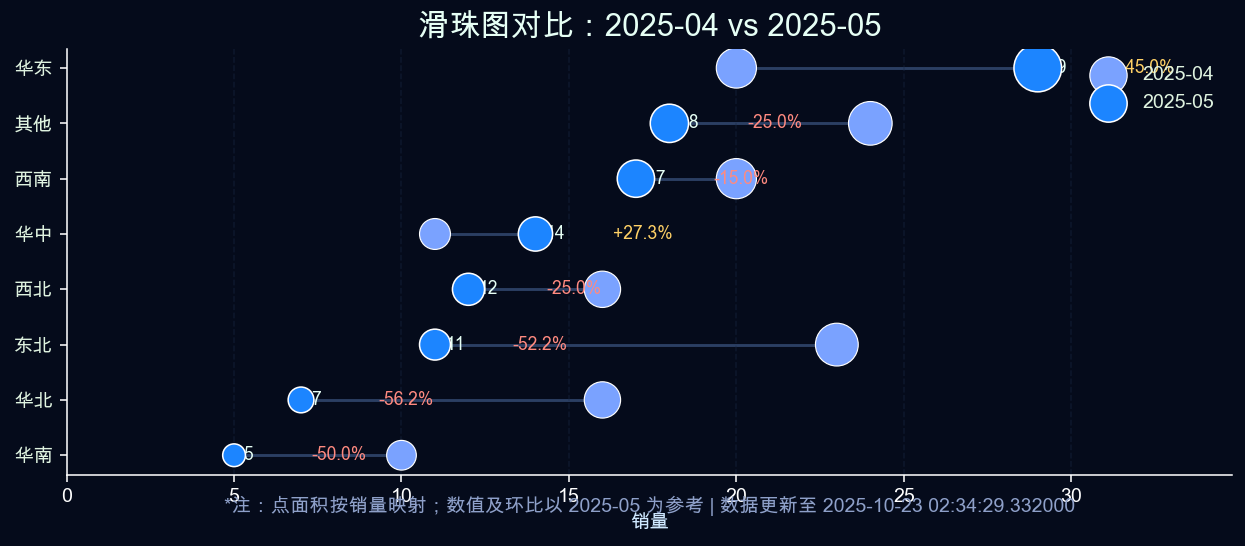

In [ ]:
value_col = QUANTITY_COL or AMOUNT_COL
category_col = next((c for c in ['region', 'category', 'product_category', 'product_name', 'province', 'store_name'] if c in df.columns), None)
date_col = PRIMARY_DATE_COL
df_month = df.dropna(subset=[date_col]).copy()
df_month['year'] = df_month[date_col].dt.year
df_month['month'] = df_month[date_col].dt.month
df_2025 = df_month[df_month['year'] == 2025]
apr = df_2025[df_2025['month'] == 4]
may = df_2025[df_2025['month'] == 5]
agg_apr = apr.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'sales_2025_04'})
agg_may = may.groupby(category_col, as_index=False)[value_col].sum().rename(columns={value_col: 'sales_2025_05'})
df_cmp = pd.merge(agg_apr, agg_may, on=category_col, how='outer').fillna(0.0)
df_cmp['pct_change'] = np.where(
    df_cmp['sales_2025_04'] == 0,
    np.where(df_cmp['sales_2025_05'] == 0, 0.0, 100.0),
    (df_cmp['sales_2025_05'] - df_cmp['sales_2025_04']) / df_cmp['sales_2025_04'] * 100
 )
df_cmp = df_cmp.sort_values('sales_2025_05', ascending=True).reset_index(drop=True)
labels = df_cmp[category_col].astype(str).tolist()
vals_apr = df_cmp['sales_2025_04'].astype(float).tolist()
vals_may = df_cmp['sales_2025_05'].astype(float).tolist()
changes = df_cmp['pct_change'].astype(float).tolist()
if not labels:
    raise ValueError('没有可绘制的数据')

y = np.arange(len(labels))
max_val = max(max(vals_apr + vals_may), 1.0)
sizes_apr = (np.array(vals_apr) / max_val) * 560 + 40
sizes_may = (np.array(vals_may) / max_val) * 560 + 40
metric_name = '销量' if value_col == QUANTITY_COL else '销售额'

plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(9, max(4, len(labels) * 0.35)), dpi=140)
fig.patch.set_facecolor('#050b1b')
ax.set_facecolor('#050b1b')
for apr_val, may_val, yi in zip(vals_apr, vals_may, y):
    ax.plot([apr_val, may_val], [yi, yi], color='#2b3f63', linewidth=1.5, zorder=1)
ax.scatter(vals_apr, y, s=sizes_apr, color='#7aa2ff', edgecolors='white', linewidth=0.6, label='2025-04', zorder=3)
ax.scatter(vals_may, y, s=sizes_may, color='#1c85ff', edgecolors='white', linewidth=0.8, label='2025-05', zorder=4)
for may_val, yi, change in zip(vals_may, y, changes):
    ax.text(may_val + max_val * 0.01, yi, f'{may_val:,.0f}', va='center', ha='left', color='#e6fff5', fontsize=9)
    ax.text(may_val + max_val * 0.08, yi, f'{change:+.1f}%', va='center', ha='left', color='#ffd166' if change >= 0 else '#ff8a80', fontsize=9)
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=10, color='#dff3e0')
ax.set_xlabel(metric_name, color='#cfe8ff')
ax.set_title('滑珠图对比：2025-04 vs 2025-05', fontsize=16, color='#e6fff5', fontweight='bold')
ax.text(0.5, -0.05, f'*注：点面积按{metric_name}映射；数值及环比以 2025-05 为参考 | 数据更新至 {NOTE_DATE}', ha='center', va='top', fontsize=10, color='#8ea0c9', transform=ax.transAxes)
ax.grid(axis='x', linestyle='--', color='#1b2a46', alpha=0.4)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.legend(frameon=False, fontsize=10, loc='upper right', labelcolor='#dff3e0')
ax.set_xlim(0, max_val * 1.2)
plt.tight_layout()
plt.show()